In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# Step 1 데이터 로드

In [3]:
kor_path = "./korean-english-park.train.ko"
eng_path = "./korean-english-park.train.en"

# Step 2 데이터 정제 및 토큰화

In [4]:
def data_open(kor_path, eng_path):
    with open(kor_path, 'r', encoding='UTF8') as f: kor = f.read().splitlines()
    with open(eng_path, 'r', encoding='UTF8') as f: eng = f.read().splitlines()
    assert len(kor) == len(eng) # 데이터 개수가 다르면 AssertionError 발생하도록.
    
    return kor, eng

In [5]:
kor, eng = data_open(kor_path, eng_path)

__set() 활용 중복 제거__

In [6]:
def remove_duplicates(korean_texts, english_texts):
    cleaned_corpus_ko = []
    cleaned_corpus_eng = []
    seen_pairs = set()
    
    for ko, eng in zip(korean_texts, english_texts):
        pair = (ko, eng)
        if pair not in seen_pairs:
            cleaned_corpus_ko.append(ko)
            cleaned_corpus_eng.append(eng)
            seen_pairs.add(pair)
            
    return cleaned_corpus_ko, cleaned_corpus_eng

In [7]:
cleaned_corpus_ko, cleaned_corpus_eng = remove_duplicates(kor, eng)

__'GN04' 프로젝트에서 사용한 코드 재사용. 각 한문, 영문 중복 데이터 제거__

In [8]:
import pandas as pd

df = pd.DataFrame({'Korean': cleaned_corpus_ko, 'English': cleaned_corpus_eng})

def extract_rows_by_pattern(df, pattern):
    mask = df['Korean'].str.contains(pattern, regex=True)
    extracted_rows = df[mask]
    extracted_rows_indices = df[mask].index
    return extracted_rows, extracted_rows_indices

In [9]:
extracted_rows, extracted_rows_indices = extract_rows_by_pattern(df, pattern='어휘 :|TOEIC 독해|번역 :|저장된 검색어|뉴스입니다.|국어사전|일어사전')
df.drop(extracted_rows_indices, inplace=True)
# 번역없이 '국제원자력기구' 라고만 쓰여있는 행 삭제
df.drop([76096, 78670], inplace=True)

In [10]:
def remove_duplicates_keep_one(df, column_name):
    df_unique = df.drop_duplicates(subset=column_name)
    return df_unique

df_ko_unique = remove_duplicates_keep_one(df, column_name='Korean')
cleaned_corpus = remove_duplicates_keep_one(df_ko_unique, column_name='English')

In [11]:
def unique(l):
    if len(l) == len(set(l)):
        print("The List is Unique!")
        return True
    else:
        print("The List is Not Unique! The amount of duplicated data is {}".format(len(l)-len(set(l))))
        return False
unique(cleaned_corpus['Korean'])
unique(cleaned_corpus['English'])

The List is Unique!
The List is Unique!


True

__정제 함수 정의__<br>
* 모든 입력을 소문자로 변환
* 알파벳, 문장부호, 한글만 남기고 모두 제거
* 문장부호 양옆에 공백 추가
* 문장 앞뒤의 불필요한 공백 제거

In [13]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # r" \1 " >> 캡처된 구두점 주위에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 공백을 하나의 공백으로 바꿉
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]+", " ", sentence)
    sentence = sentence.strip() # 앞뒤 공백을 제거
    
    return sentence

In [14]:
cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : preprocess_sentence(x))
cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x : preprocess_sentence(x))

/tmp/ipykernel_31/3213031578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : preprocess_sentence(x))
/tmp/ipykernel_31/3213031578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x : preprocess_sentence(x))


In [15]:
cleaned_corpus.head()

,Korean,English
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다,like all optical mice but it also doesn t need...
3,79 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든...,uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,intelligence officials have revealed a spate o...


In [16]:
eng_corpus = cleaned_corpus['English'].tolist()
kor_corpus = cleaned_corpus['Korean'].tolist()

In [17]:
len(kor_corpus)

74816

In [18]:
len(eng_corpus)

74816

__SentencePiece를 활용해 토큰화__

In [19]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = './sp.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    templates = '--input={}\
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={}\
    --vocab_size={}\
    --character_coverage={}\
    --model_type={}'
    
    train_input_file = temp_file
    prefix = '{}_spm'.format(lang) # 저장될 tokenizer 모델에 붙는 이름
    
    pad_id=pad_id # <pad> token을 0으로 설정
    bos_id=bos_id # <start> token을 1으로 설정
    eos_id=eos_id # <end> token을 2으로 설정
    unk_id=unk_id # <unknown> token을 3으로 설정
    character_coverage=1.0 # to reduce character set
    
    vocab_size = vocab_size
    model_type = 'unigram' # Choose from unigram(default), bpe, char, or word
    
    cmd = templates.format(train_input_file,
                          pad_id,
                          bos_id,
                          eos_id,
                          unk_id,
                          prefix,
                          vocab_size,
                          character_coverage,
                          model_type)
    
    spm.SentencePieceTrainer.Train(cmd)
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}.model'.format(prefix))
    
    return tokenizer

In [20]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000


ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp.temp    --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --model_prefix=ko_spm    --vocab_size=20000    --character_coverage=1.0    --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  b

True

es: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: ./sp.temp
trainer_interface.cc(385) LOG(INFO) Loaded all 74807 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=9961443
trainer_interface.cc(487) LOG(INFO) Alphabet size=37
trainer_interface.cc(488) LOG(INFO) Final character coverage=1
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 74807 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(19

In [21]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = ko_tokenizer.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(ko_tokenizer.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(ko_tokenizer.DecodeIds(tokensIDs))

[853, 10, 790, 11, 3235, 10, 695, 45, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [22]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = en_tokenizer.EncodeAsIds('I ate lunch.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(en_tokenizer.SampleEncodeAsPieces('I ate lunch.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(en_tokenizer.DecodeIds(tokensIDs))

[1, 36, 3, 22, 94, 5151, 3, 2]
['<s>', '▁', 'I', '▁at', 'e', '▁lunch', '.', '</s>']
 ⁇  ate lunch ⁇ 


In [23]:
tok_kor = []
tok_eng = []

for i in range(len(kor_corpus)):
    tokenized1 = ko_tokenizer.EncodeAsIds(kor_corpus[i])
    tokenized2 = en_tokenizer.EncodeAsIds(eng_corpus[i])
    tok_kor.append(tokenized1)
    tok_eng.append(tokenized2)


__4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)__

In [24]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    if len(tok_kor[idx]) <= 50 and len(tok_eng[idx]) <= 50:
        src_corpus.append(tok_kor[idx])
        tgt_corpus.append(tok_eng[idx])

  0%|          | 0/74816 [00:00<?, ?it/s]

In [25]:
print(len(src_corpus))
print(len(tgt_corpus))

71680
71680


In [26]:
num_tokens = [len(tokens) for tokens in src_corpus]
num_tokens = np.array(num_tokens)
print('문장길이 최대: ', np.max(num_tokens))

문장길이 최대:  50


In [27]:
num_tokens = [len(tokens) for tokens in tgt_corpus]
num_tokens = np.array(num_tokens)
print('문장길이 최대: ', np.max(num_tokens))

문장길이 최대:  50


In [28]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [29]:
enc_train[0]

array([ 1095,   356,   541,   533,     6,  1371,  1918,     7,  1243,
         222,  2701,   981,    26, 10654,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [30]:
dec_train[0]

array([   1,  301,    7, 1349, 8049,   12,   18,   49,  100,   93,  231,
         44,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

# Step 3 모델 설계

__1. positional Encoding layer__

In [31]:
# pos : 한 문장의 전체 sequence_length 내에 존재하는 각 단어의 time-step
# d_model : embedding layer의 차원수
# i : embedding layer 차원의 인덱스

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

__2. Multi-Head Attention__

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        # Q, K, V의 shape은 (batch_size, num_heads, seq_length, depth) 
        # d_k는 tf.Tensor(depth, shape=(), dtype=float32)을 반환
        # 즉, 만일 depth이 256이라면 실수 256.0을 반환함.
        d_k = tf.cast(K.shape[-1], tf.float32) 
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)
        
        # padding mask인 mask는 padding token이 있는 곳을 1로 마킹함.
        # 큰 음수를 곱해서 scaled_qk에 더하면 padding token이 있는 곳이 큰 음수가 됨.
        # 이에 이후 softmax 함수를 거치면 해당 위치에 대한 가중치가 0에 가깝게 설정됨.
        if mask is not None: scaled_qk += (mask * -1e9)  
        
        # axis=-1은, input tensor의 마지막 dimension을 따라 softmax를 행하라는 뜻
        # 마지막 dimension은 문장내의 각 position의 attention score를 의미함.
        # attention scoare를 모두 합하면 1이 되도록 normalize 해주는 과정
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        
        # 이 과정에 최종적으로 multihead로 쪼갰던 Q, K, V가 다 합쳐짐
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        # split_x의 shape을 (batch_size, seq_length, num_heads, depth)로 reshape
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        # shape 순서를 (batch_size, num_heads, seq_length, depth)로 바꿈.
        # 이는 self-attention heads의 병렬 연산을 위함.
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        # d_model의 차원을 갖는 embedding layer 통과(Dense layer)
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

__3. Position-wise Feed-Forward Network__

* d_ff 차원을 갖는 Dense 층을 거쳐 d_ff 공간으로 매핑하고 ReLU 활성화 함수를 거침
* 다시 d_model 차원을 갖는 Dense 층을 거쳐 원래 갖던 차원으로 되돌림.

In [33]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

__4. Encoder Layer__

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

__5. Decoder Layer__

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

__6. Encoder Decoder class 정의__

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

__6. Transformer 구현__

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.3,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

# 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 
# 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라 연산 불가능
# 연산이 가능하도록 수정
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

__7. mask 생성__

In [39]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 4 훈련하기

### 1. 2 Layer를 가지는 Transformer를 선언
(하이퍼파라미터는 자유롭게 조절합니다.)

In [40]:
n_layers = 2
d_model = 512 # Embedding layer 차원수
n_heads = 8
d_ff = 2048
dropout = 0.3
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 50
warmup_steps = 4000

# Transformer class의 생성자에 있는 인자들은 다 넣어줘야 함.
model = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=dropout)


### 2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언 및 이를 포함하는 Adam Optimizer 선언 

In [41]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model, warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 3. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [43]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
    
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    
    # 계산된 loss에 tf.GradientTape()을 적용해 학습 진행
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        
    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5. 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [44]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [45]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [46]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [49]:
from tqdm import tqdm_notebook

BATCH_SIZE = 64
EPOCHS = 10
examples = ["오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)
    
    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                  dec_train[idx:idx+BATCH_SIZE],
                  model,
                  optimizer)
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    for example in examples:
        translate(example, model, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_31/4092688190.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the cities
Input: 커피는 필요 없다.
Predicted translation: need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in death


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president
Input: 시민들은 도시 속에 산다.
Predicted translation: in cities
Input: 커피는 필요 없다.
Predicted translation: need to take need coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people seven killed seven others were reported


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama remains president
Input: 시민들은 도시 속에 산다.
Predicted translation: cities is to urban in a city
Input: 커피는 필요 없다.
Predicted translation: need for don t need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed or missing


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city of desist
Input: 커피는 필요 없다.
Predicted translation: need to take need is need yet need for need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in death


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama s healthy
Input: 시민들은 도시 속에 산다.
Predicted translation: city is a city
Input: 커피는 필요 없다.
Predicted translation: there is no need for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven deaths from seven deaths


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s place is president
Input: 시민들은 도시 속에 산다.
Predicted translation: cities are cities in the city
Input: 커피는 필요 없다.
Predicted translation: need need for need injury
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama picked up town barack obama s takes town
Input: 시민들은 도시 속에 산다.
Predicted translation: cities is crowded for cities
Input: 커피는 필요 없다.
Predicted translation: need are not at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed seven others


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s staged almost certainly
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city they cities
Input: 커피는 필요 없다.
Predicted translation: need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths are in deaths


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is staging a stagle obama
Input: 시민들은 도시 속에 산다.
Predicted translation: cities is to citizens
Input: 커피는 필요 없다.
Predicted translation: need at the coffee it need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are among the deaths


  0%|          | 0/1120 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president s certain guys obama s ex president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is san francisco
Input: 커피는 필요 없다.
Predicted translation: need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead while another injured


# Step 5 훈련결과

__1. 번역 결과 확인__

In [51]:
trans_list=[]
print('예문')
print('='*50)
for idx, sen in enumerate(examples):
    print(f'> {str(idx+1)}. {sen}')

    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sen, model, ko_tokenizer, en_tokenizer)
    trans_list.append(result)
print('\n')
print('번역문')
print('='*50)
for idx, sen in enumerate(trans_list):
    print(f'> {str(idx+1)}. {sen}')

print('\n')
print('Hyperparameters')
print('='*50)

print('n_layers :',n_layers)
print('d_model :',d_model)
print('n_heads :',n_heads)
print('d_ff :',d_ff)
print('dropout :',dropout)
print('Warmup_steps :',warmup_steps)
print('BATCH_SIZE  :',BATCH_SIZE )
print('EPOCHS  :',EPOCHS )

예문
> 1. 오바마는 대통령이다.
> 2. 시민들은 도시 속에 산다.
> 3. 커피는 필요 없다.
> 4. 일곱 명의 사망자가 발생했다.


번역문
> 1. the president s certain guys obama s ex president
> 2. the city is san francisco
> 3. need
> 4. seven people are dead while another injured


Hyperparameters
n_layers : 2
d_model : 512
n_heads : 8
d_ff : 2048
dropout : 0.3
Warmup_steps : 4000
BATCH_SIZE  : 64
EPOCHS  : 10


__2. Attention Map 시각화__

Input: 오바마는 대통령이다.
Predicted translation: the president s certain guys obama s ex president
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


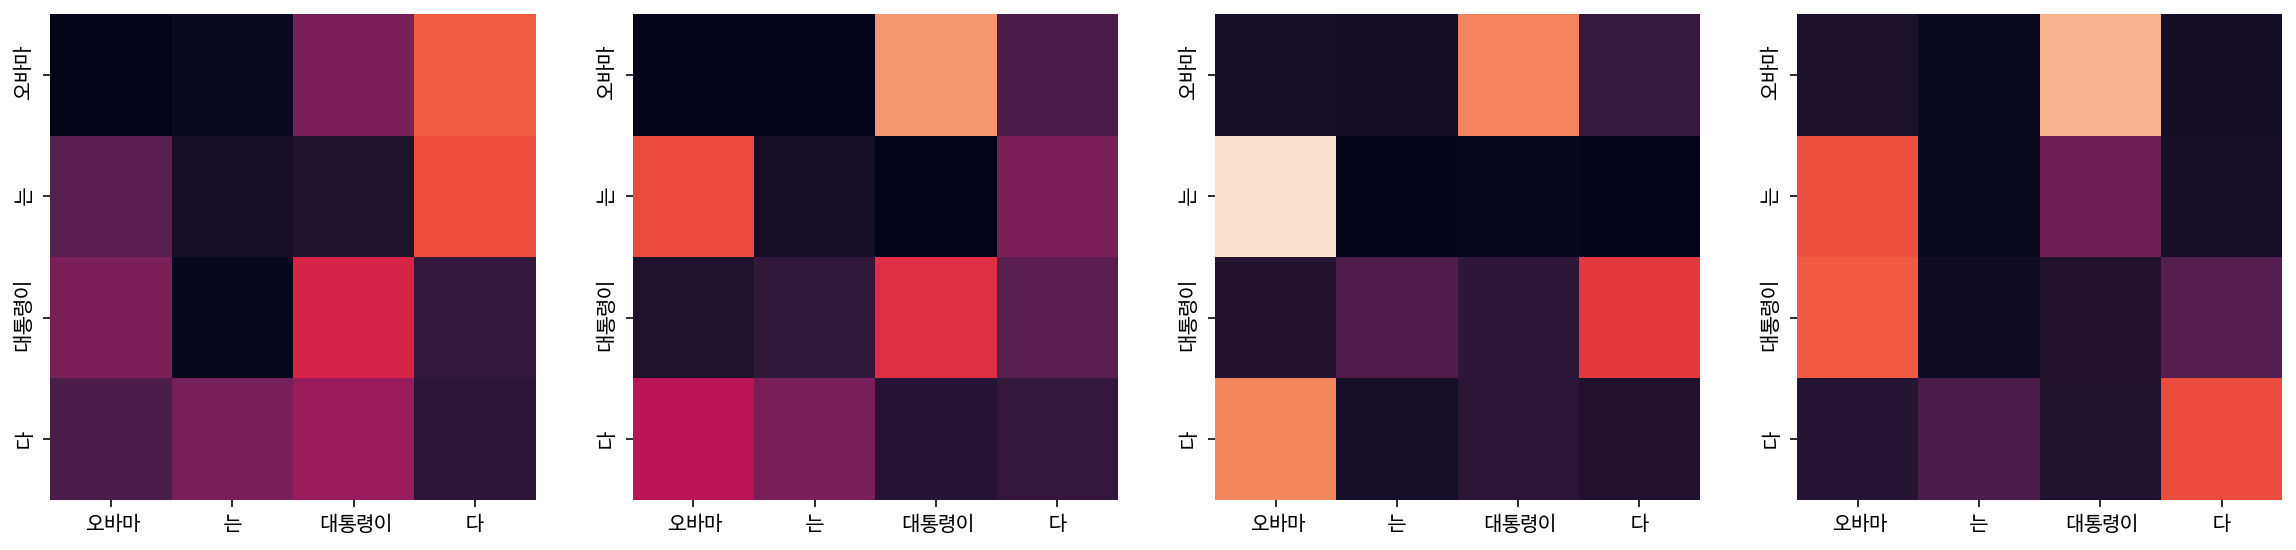

Encoder Layer 2


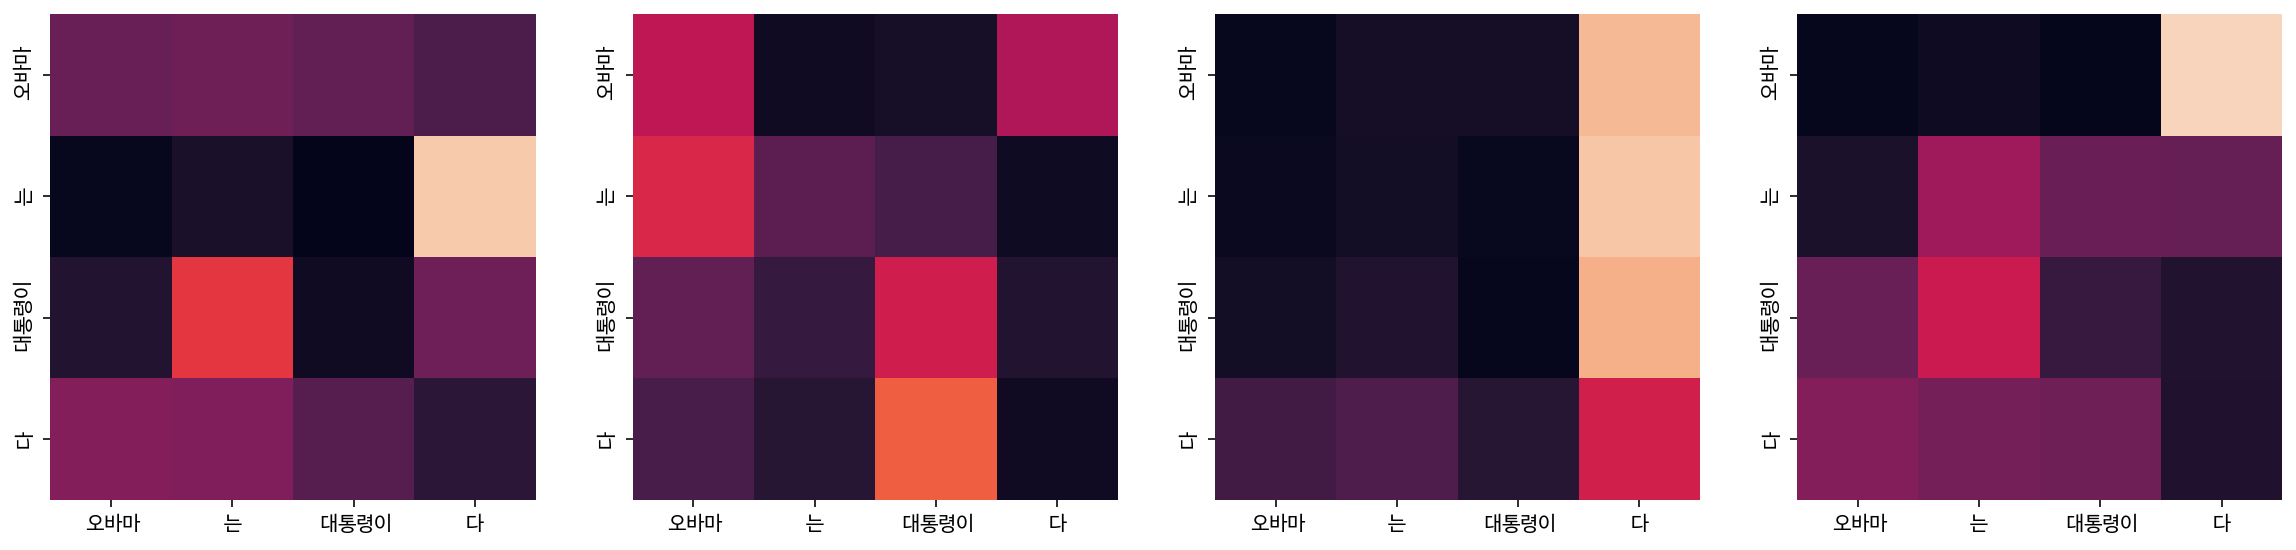

Decoder Self Layer 1


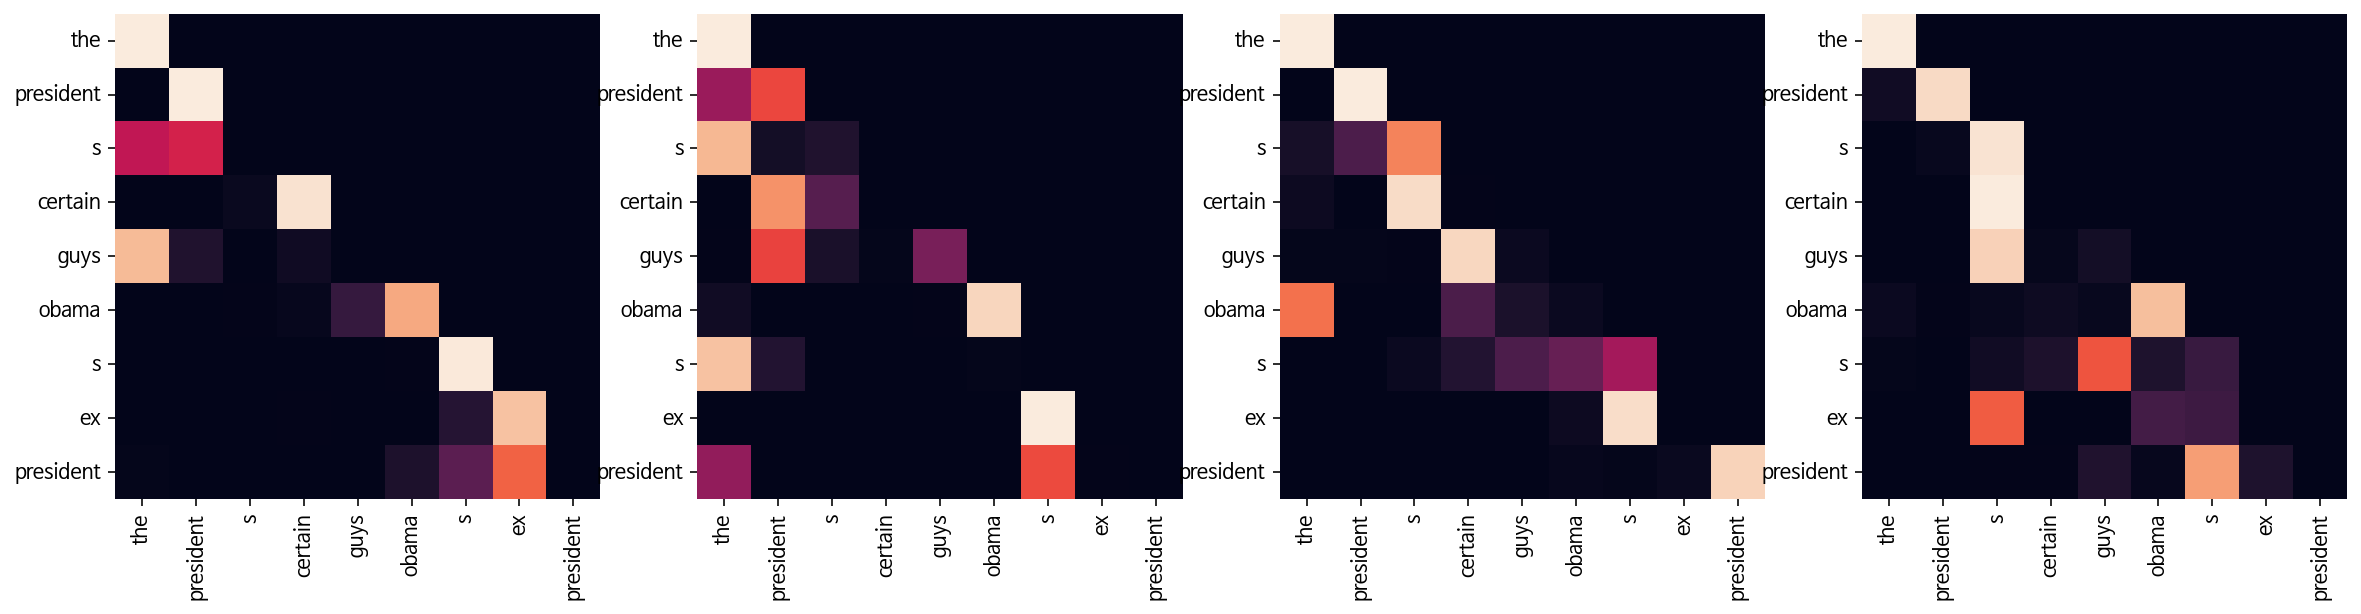

Decoder Src Layer 1


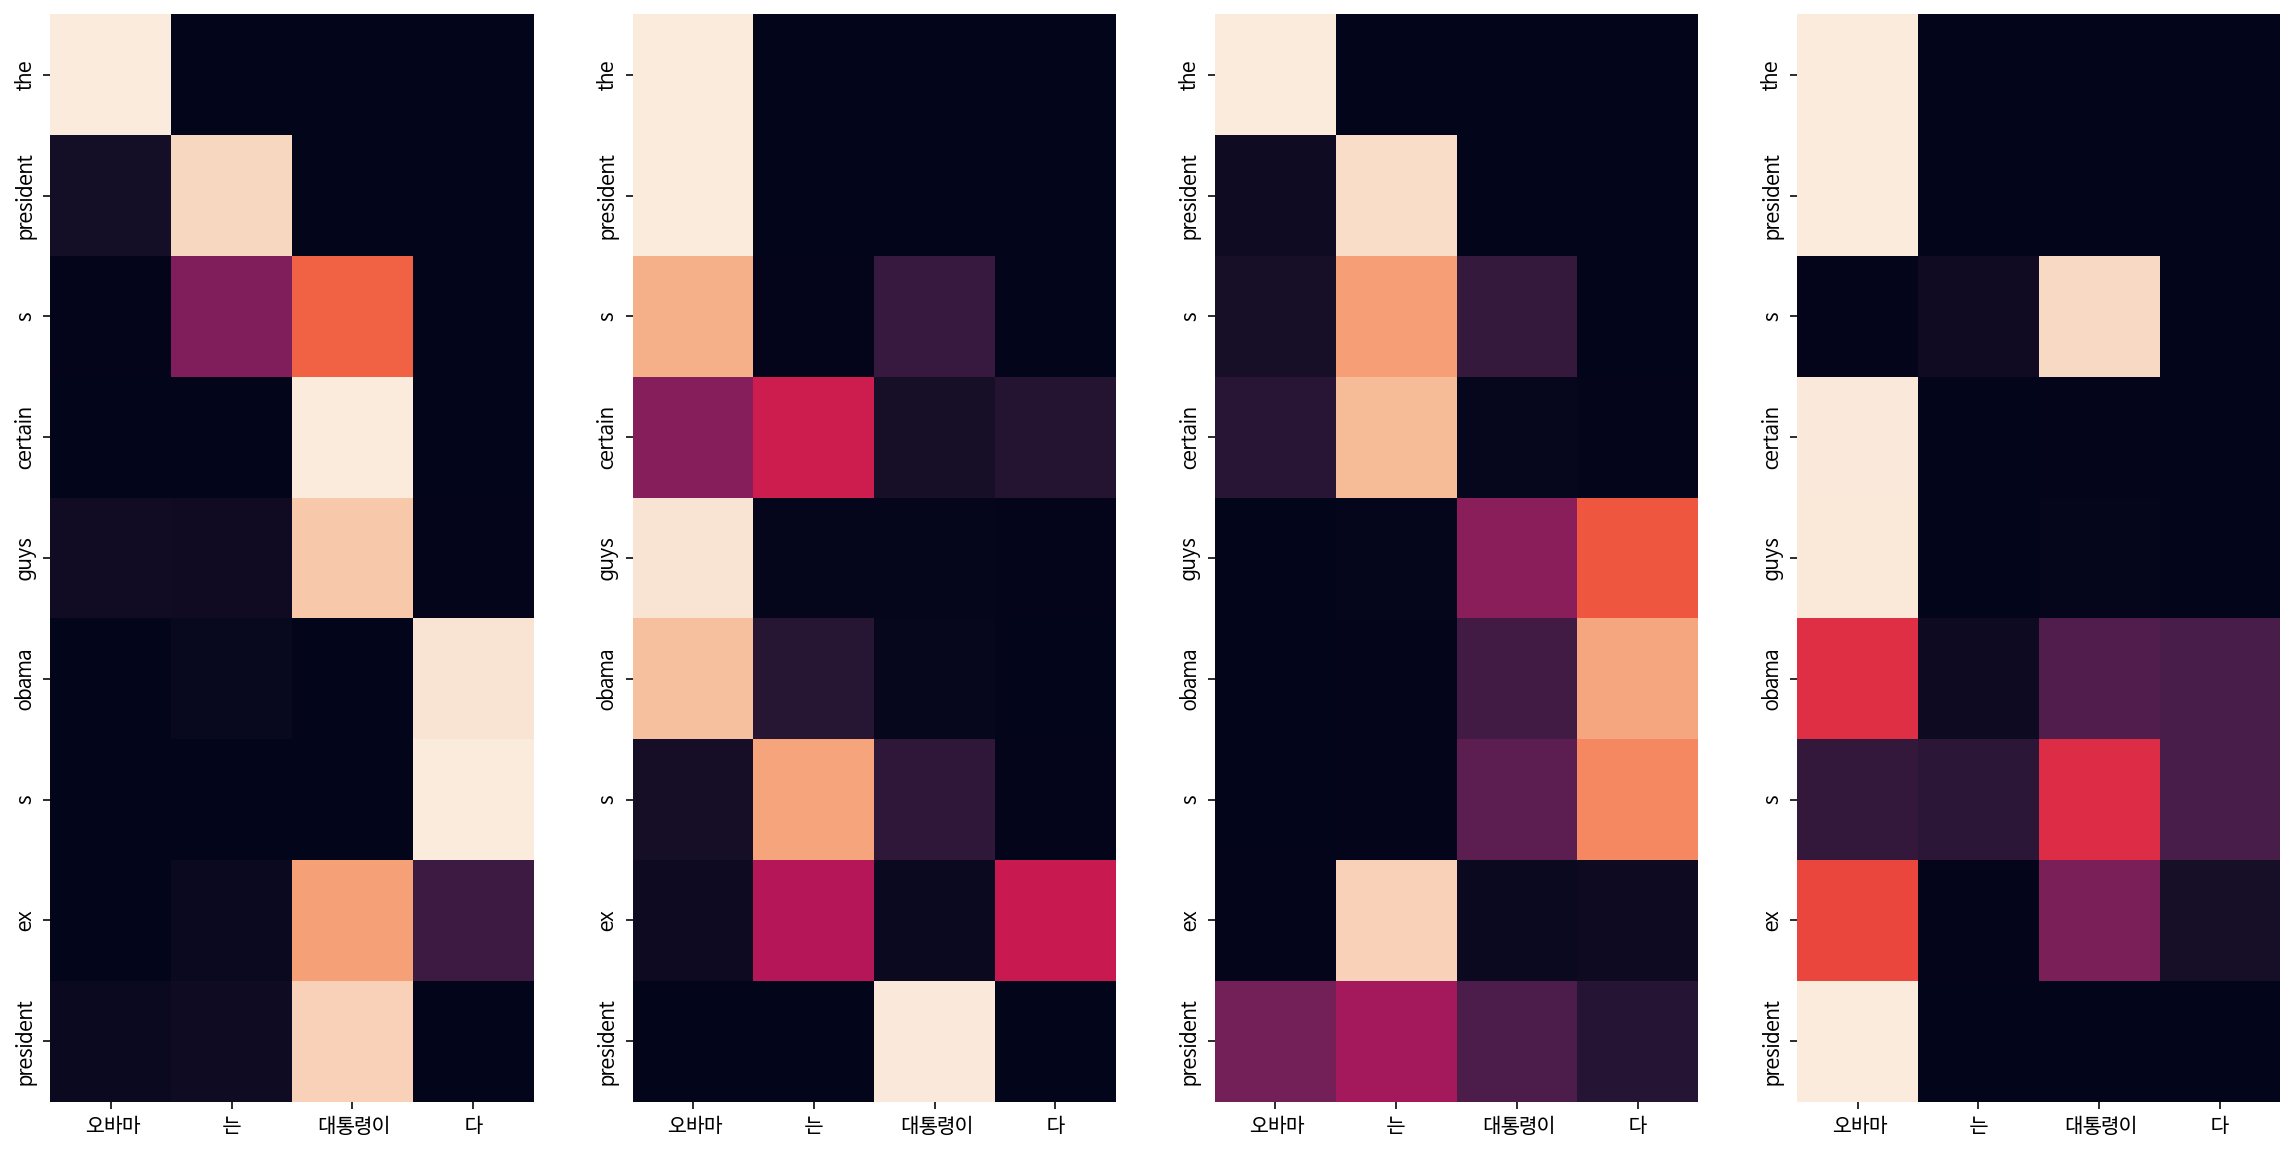

Decoder Self Layer 2


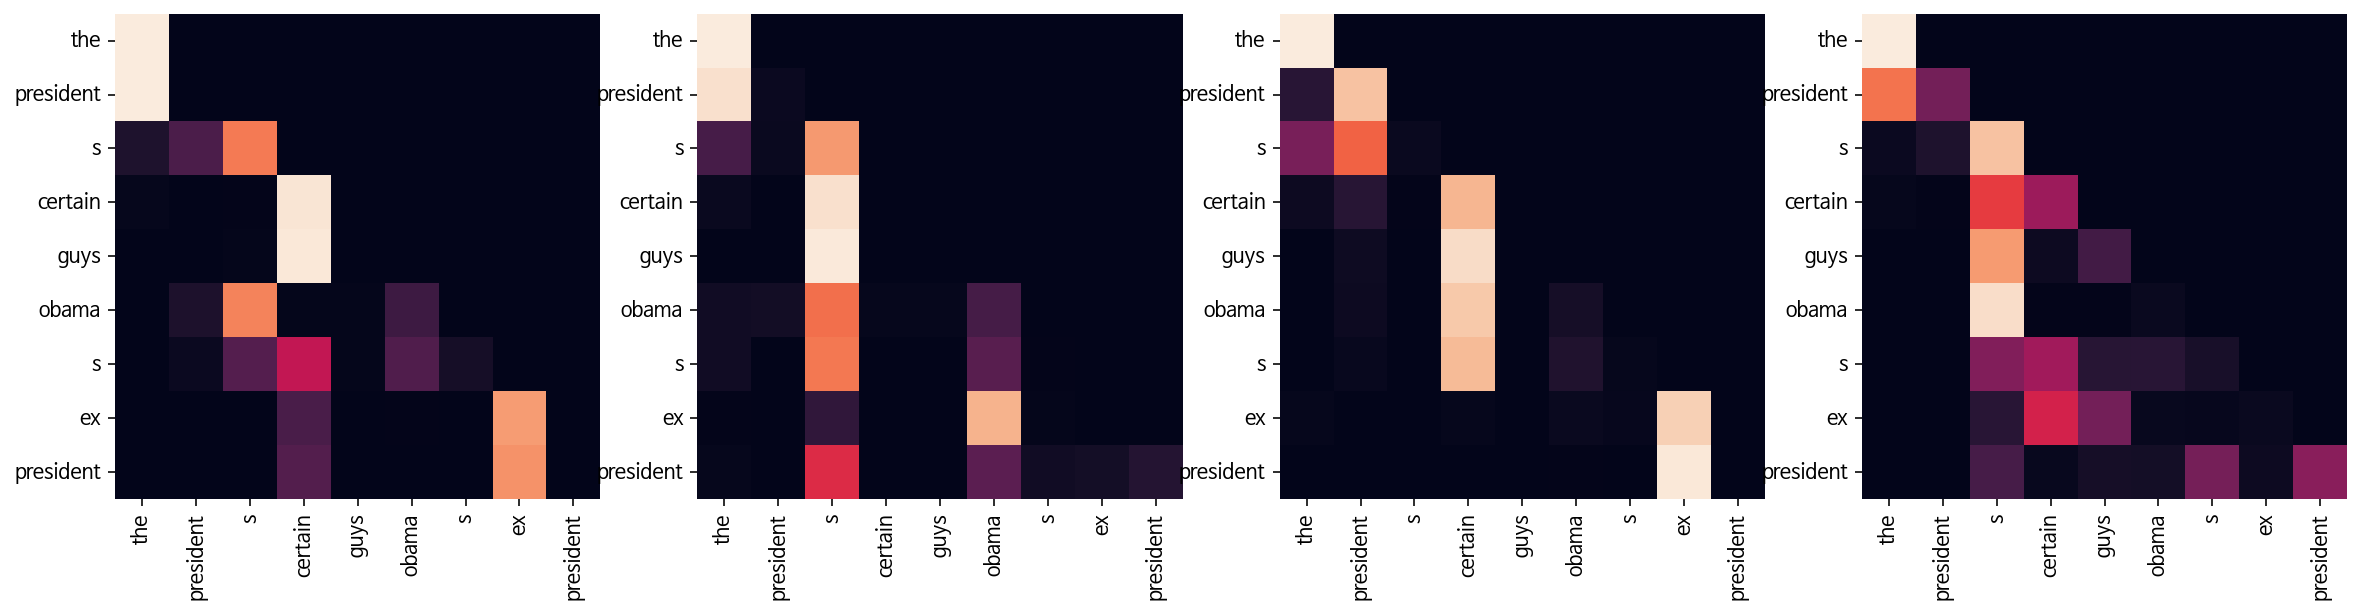

Decoder Src Layer 2


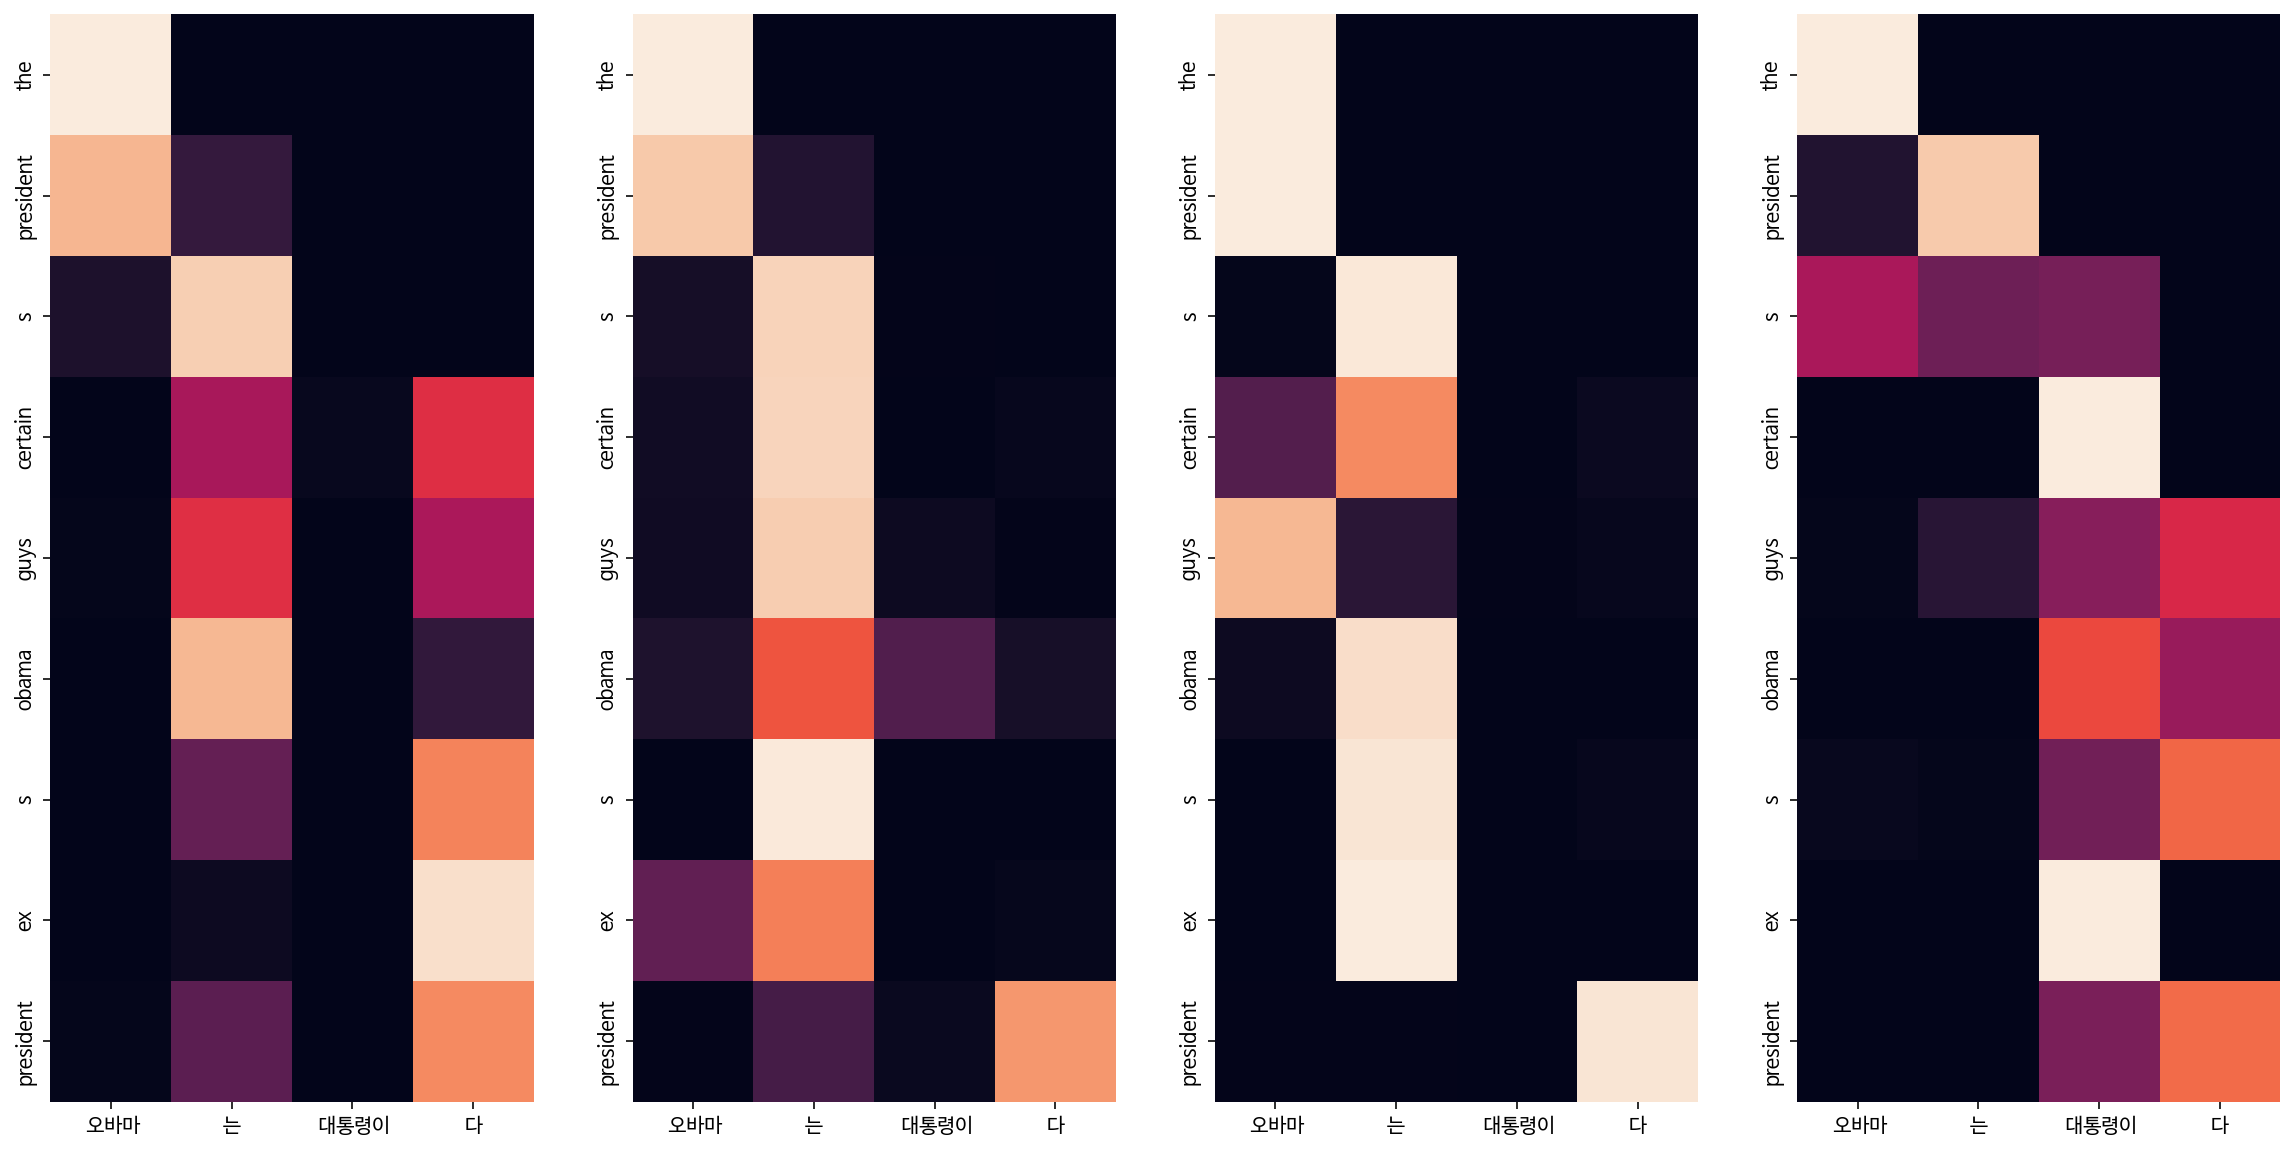

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is san francisco
Encoder Layer 1


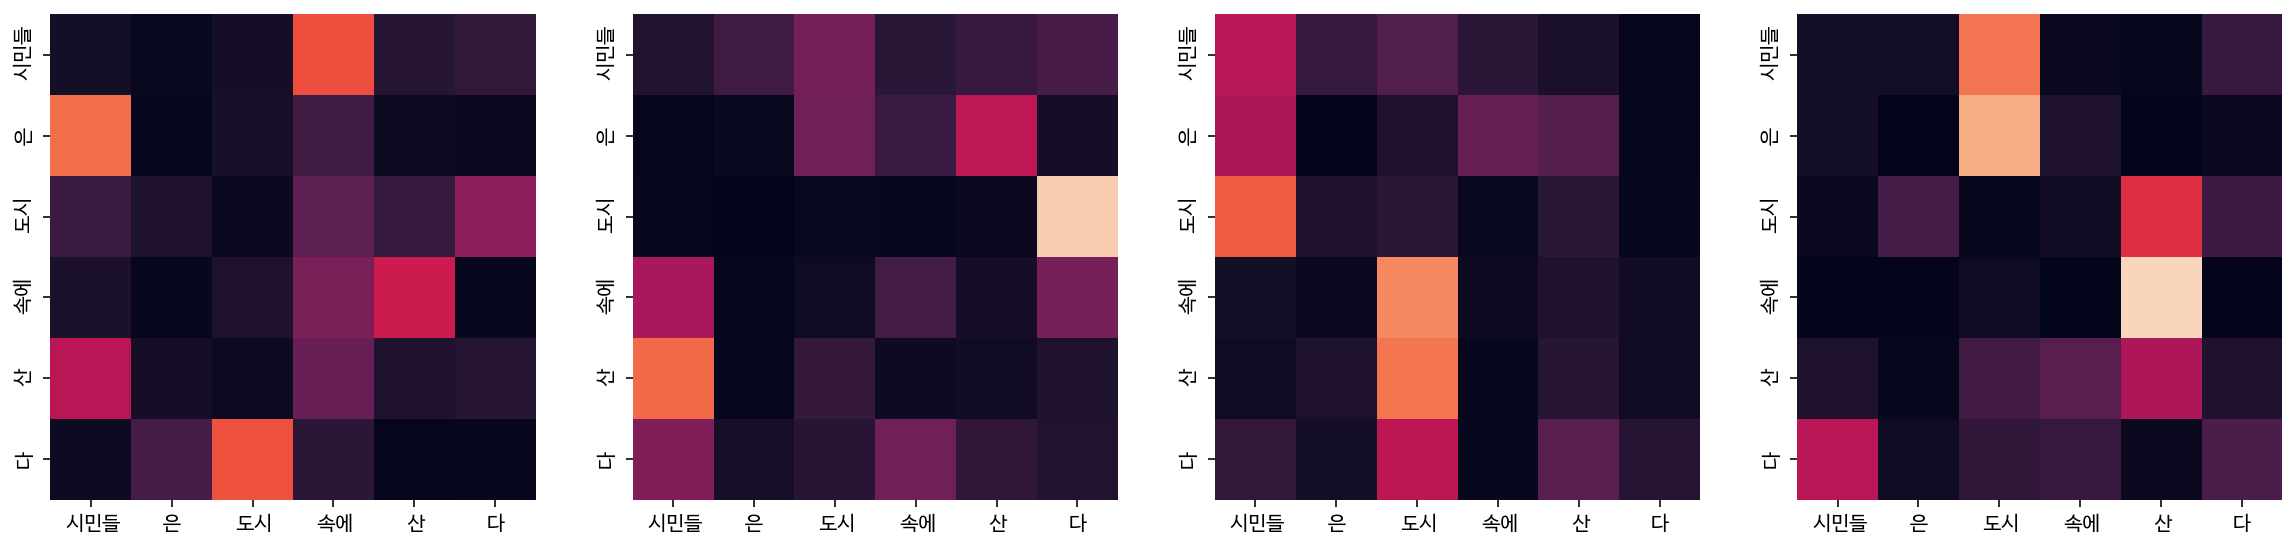

Encoder Layer 2


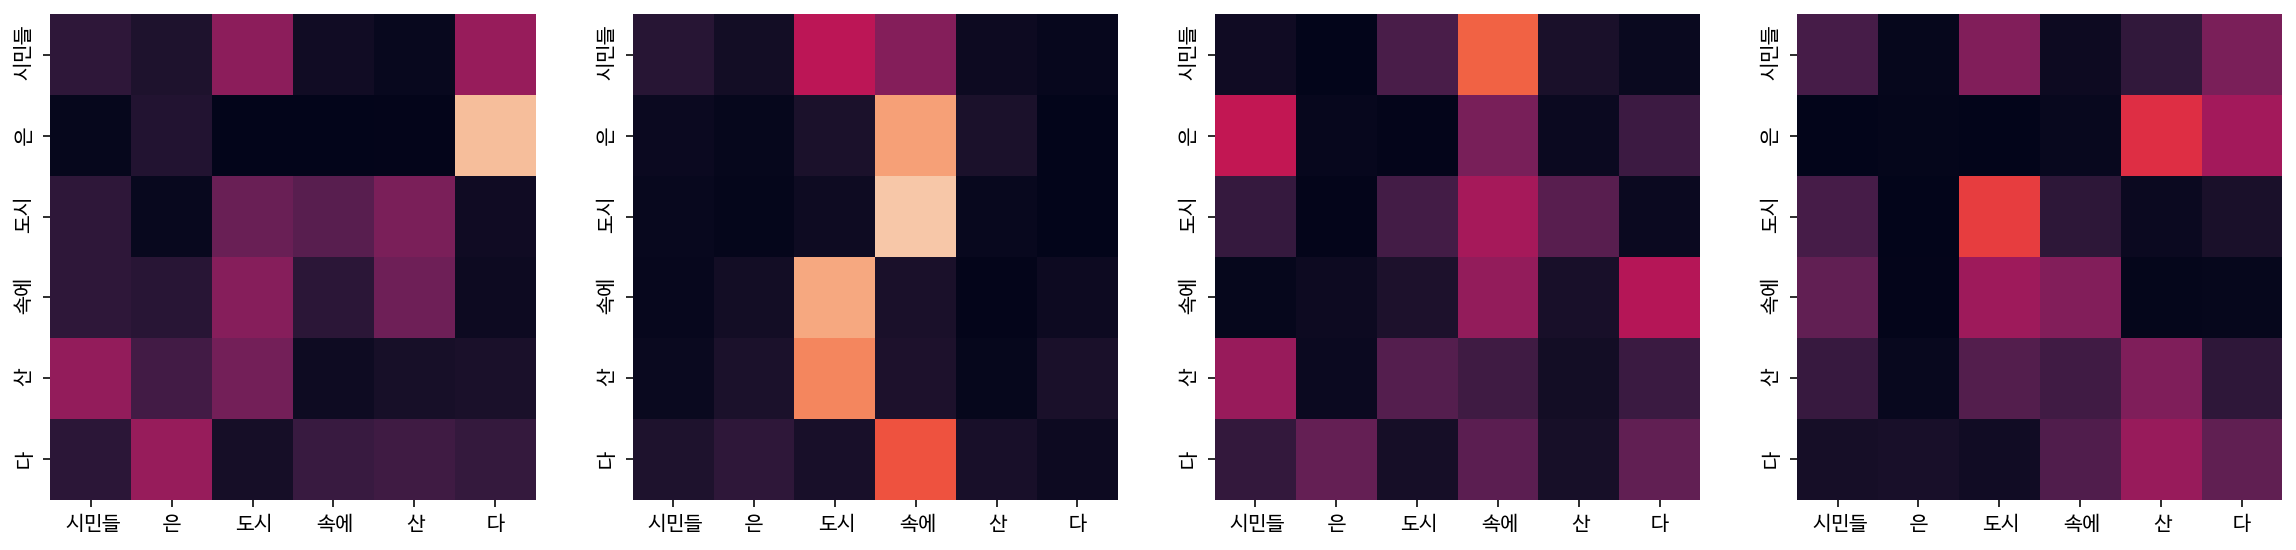

Decoder Self Layer 1


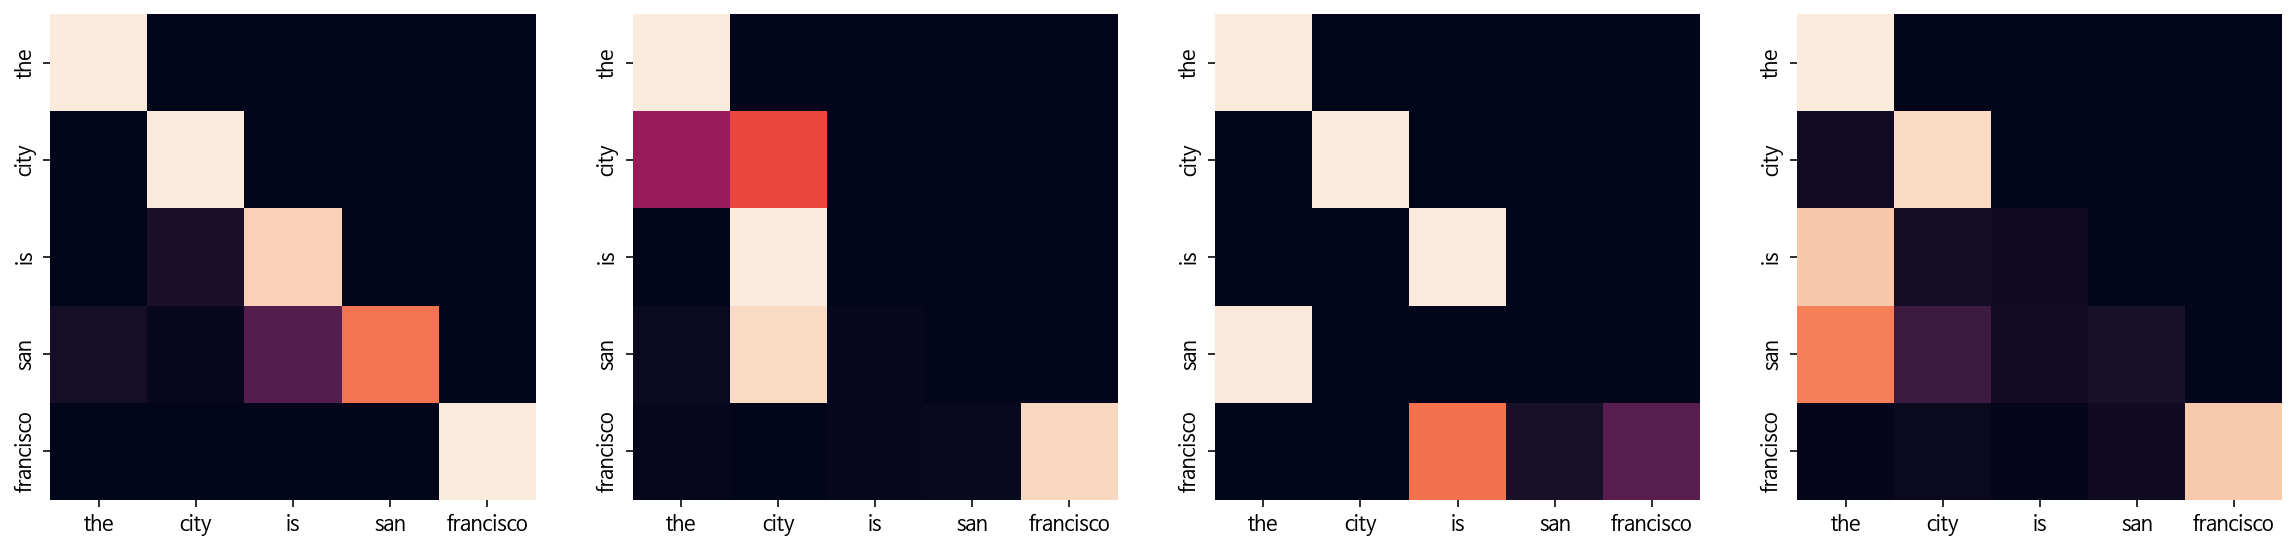

Decoder Src Layer 1


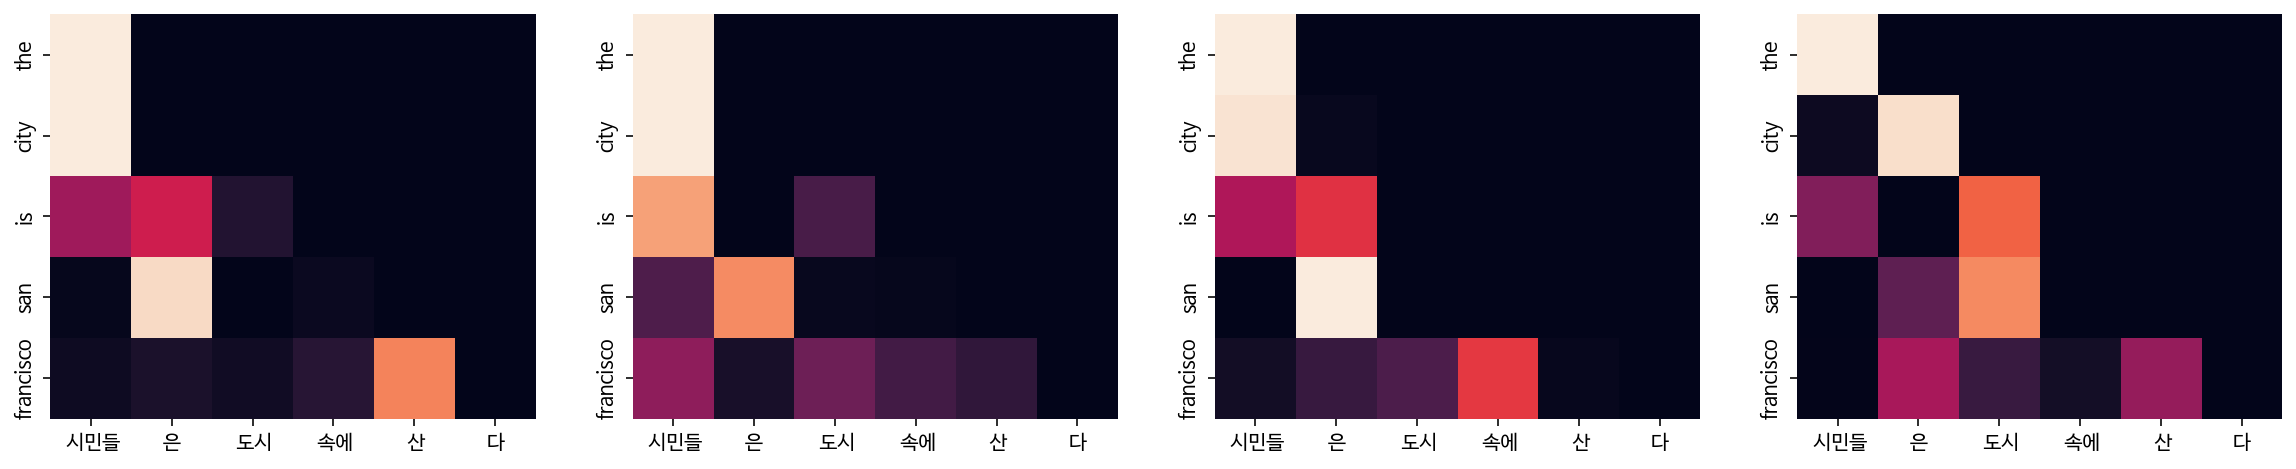

Decoder Self Layer 2


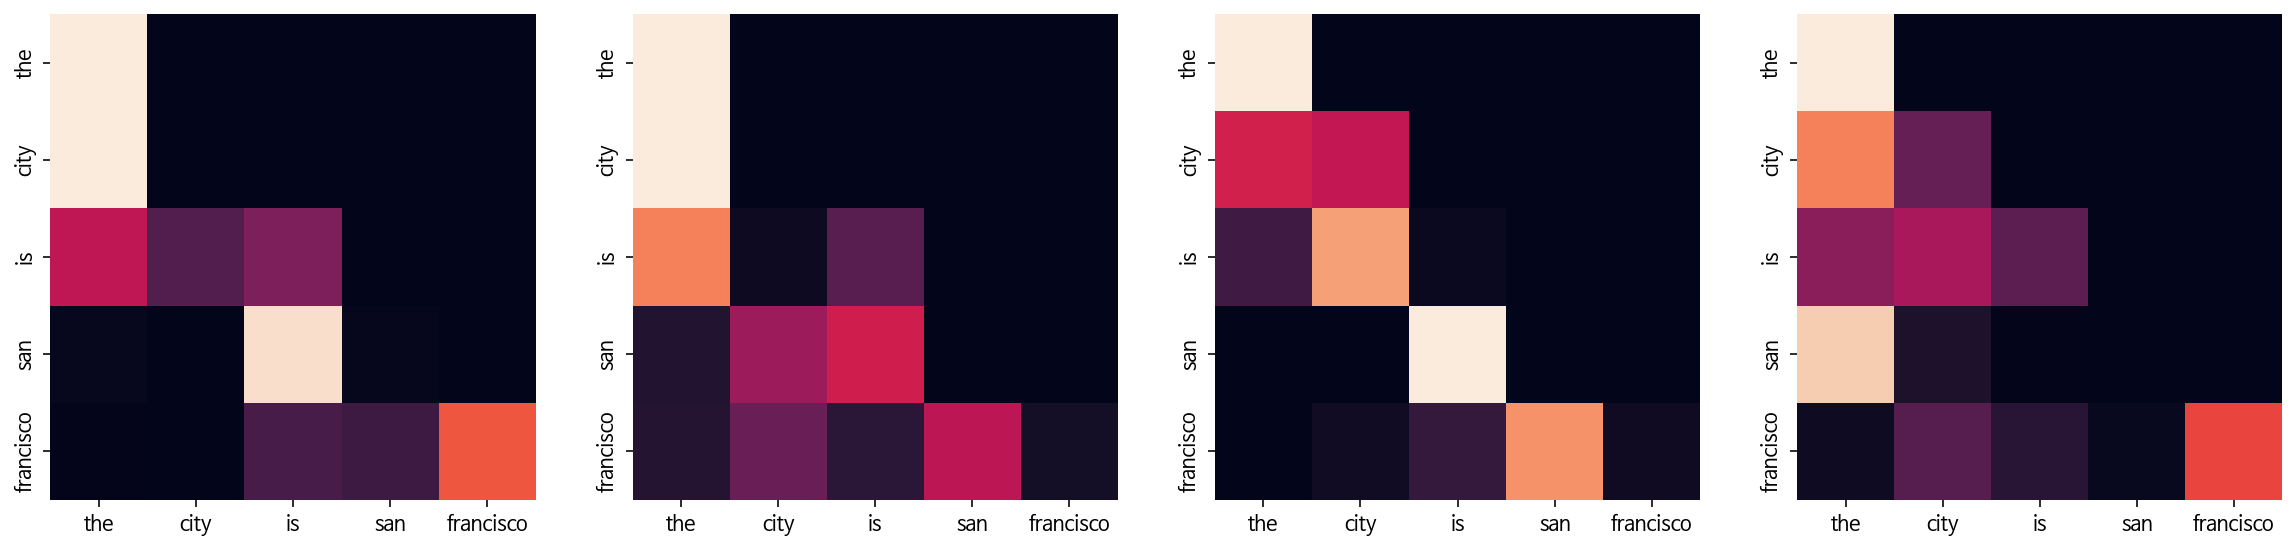

Decoder Src Layer 2


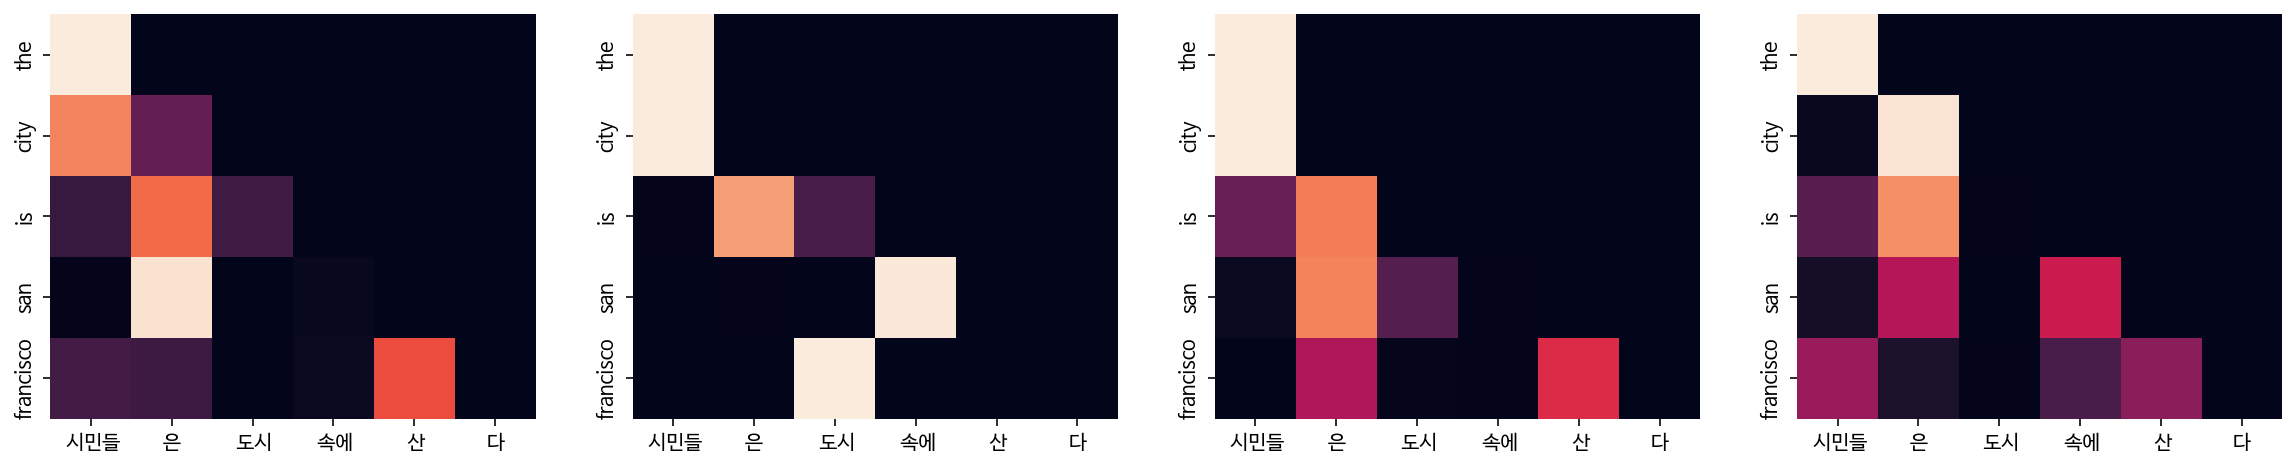

Input: 커피는 필요 없다.
Predicted translation: need
Encoder Layer 1


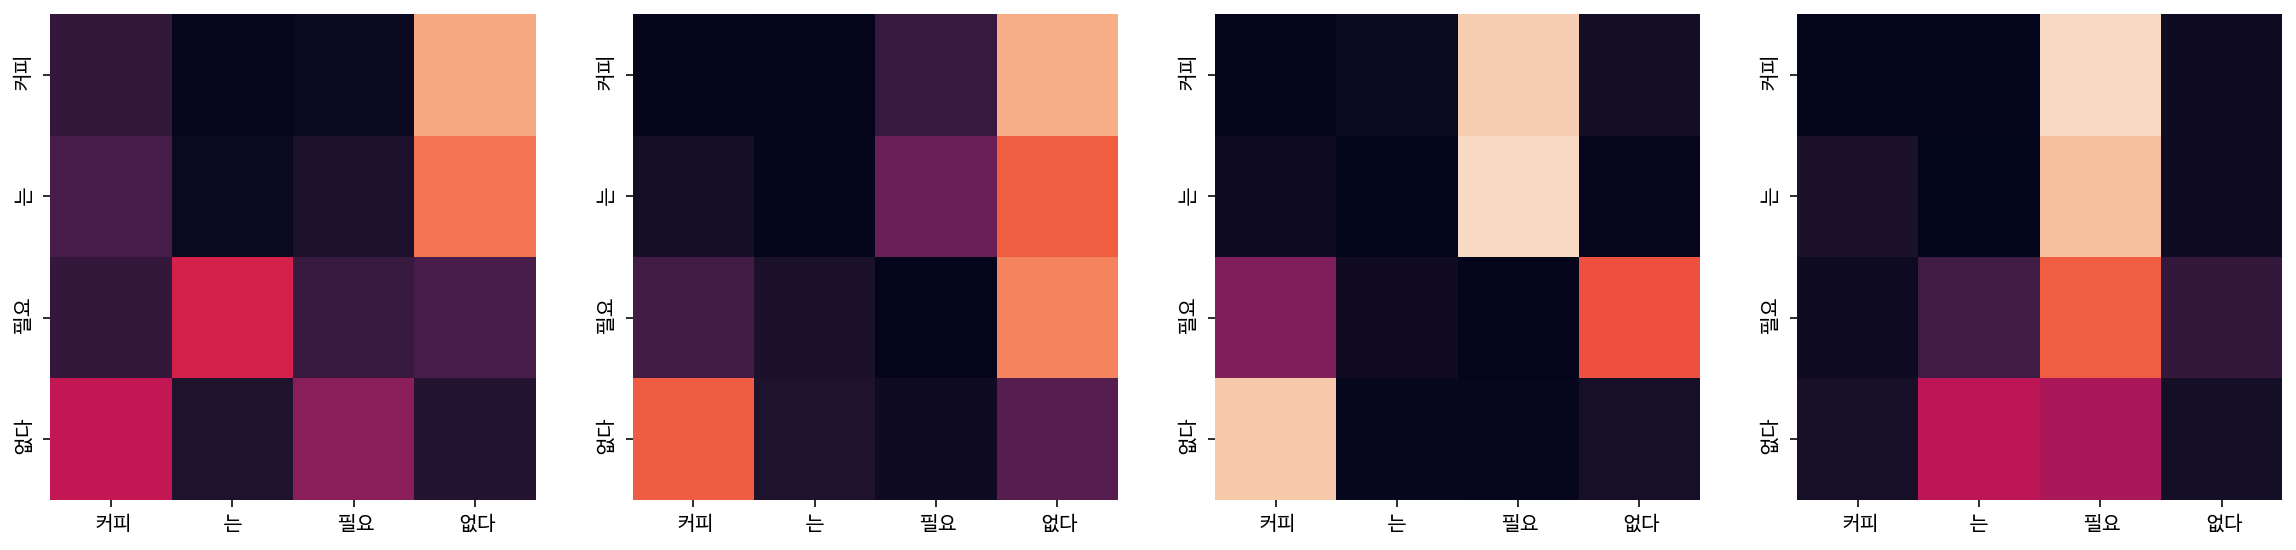

Encoder Layer 2


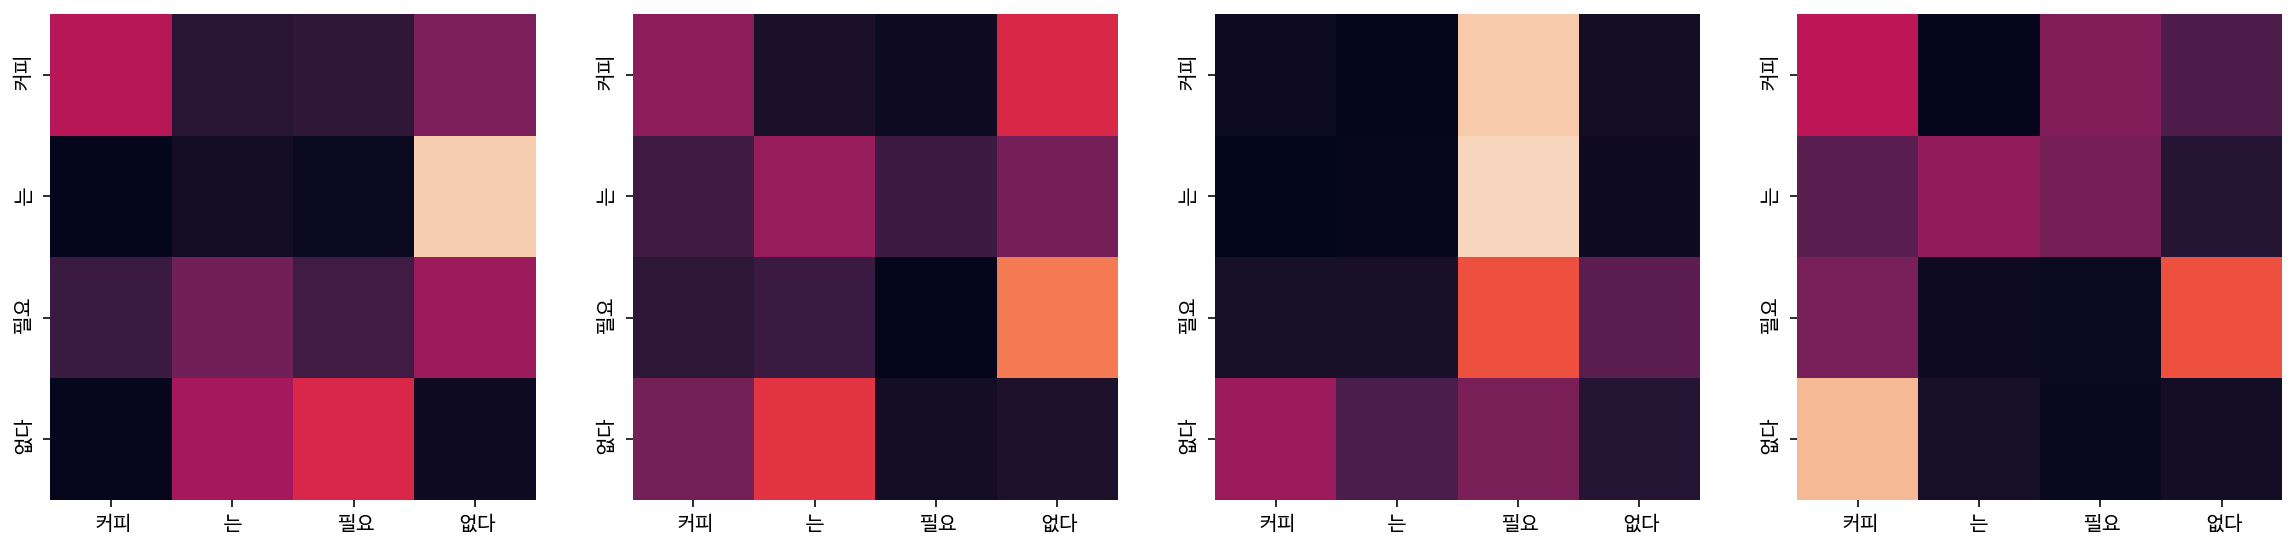

Decoder Self Layer 1


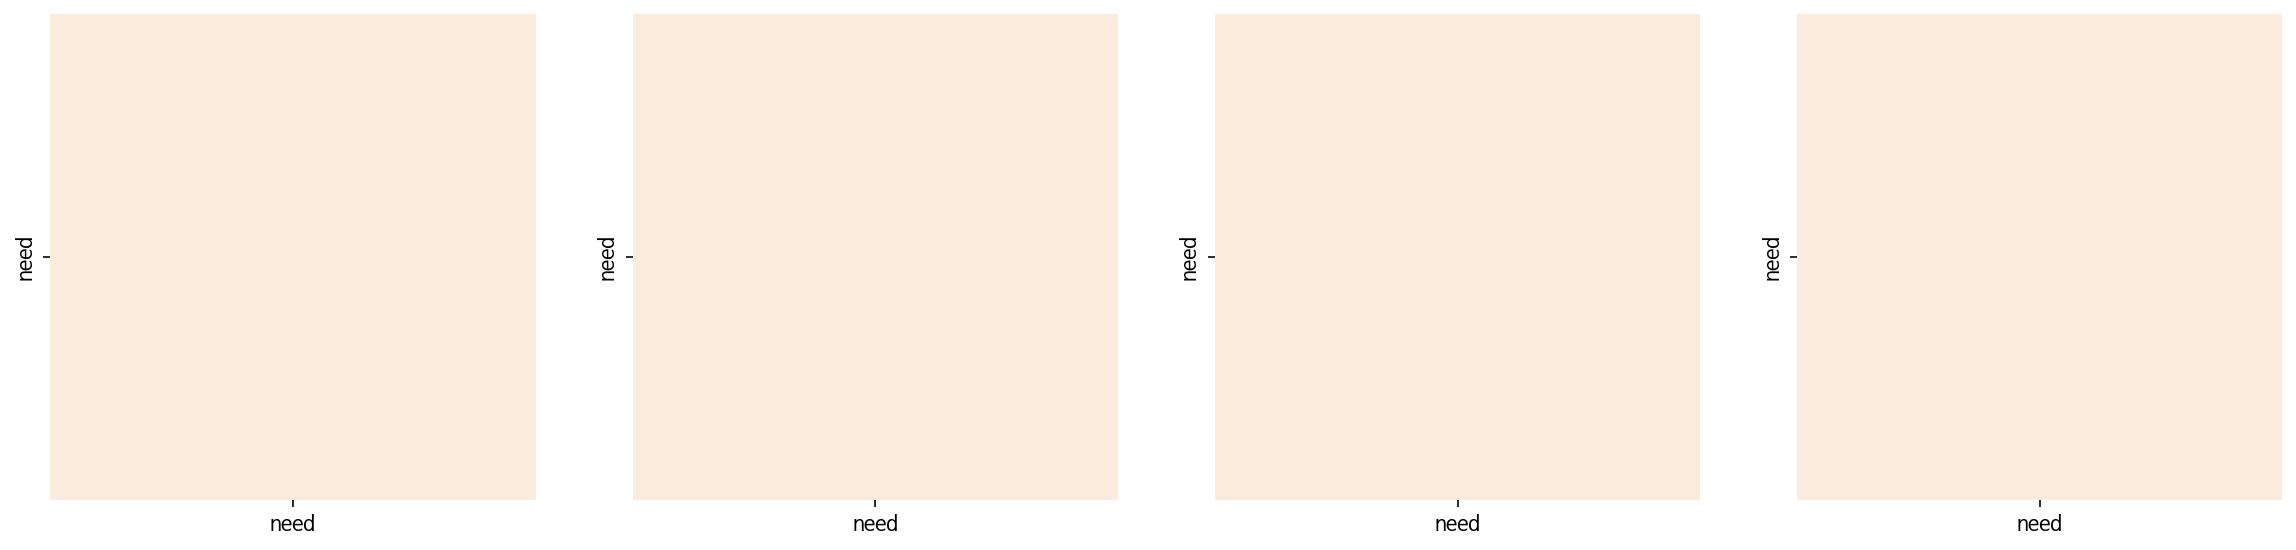

Decoder Src Layer 1


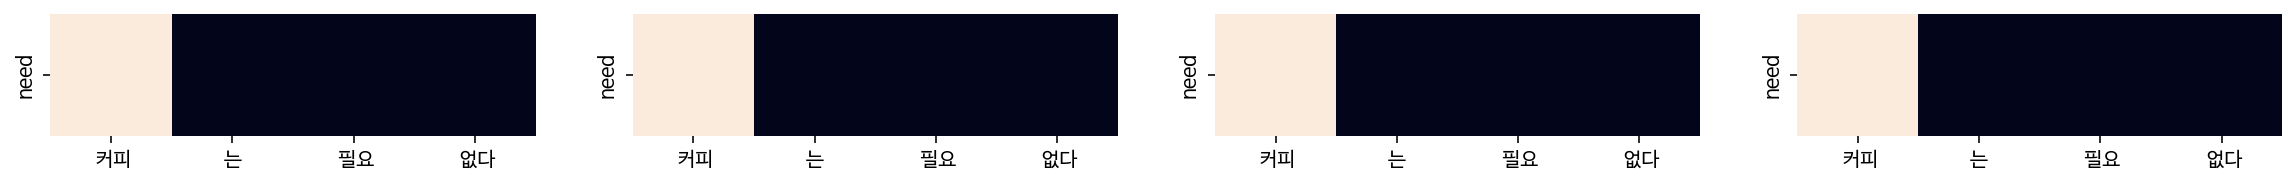

Decoder Self Layer 2


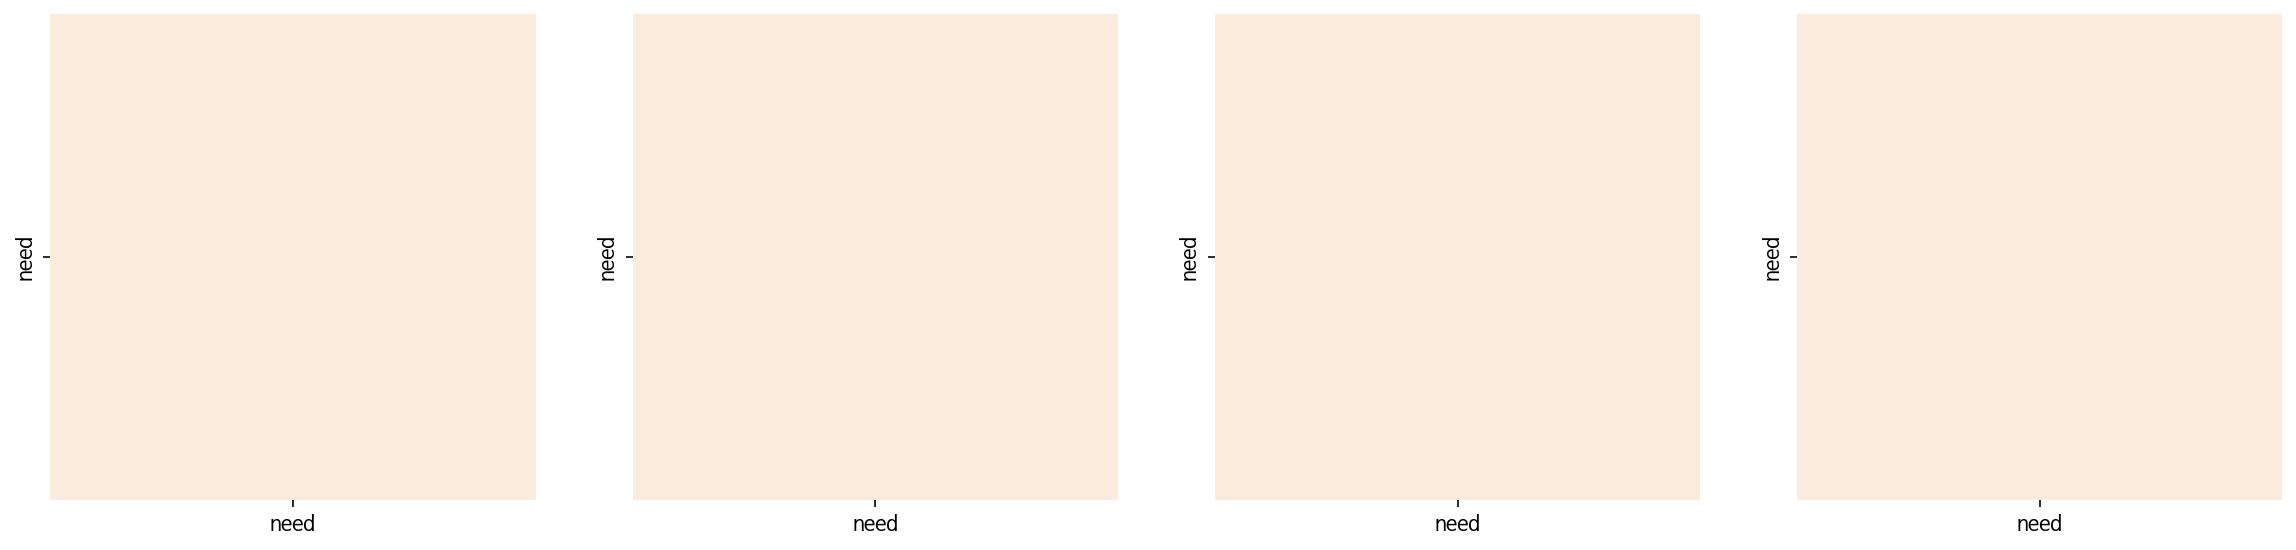

Decoder Src Layer 2


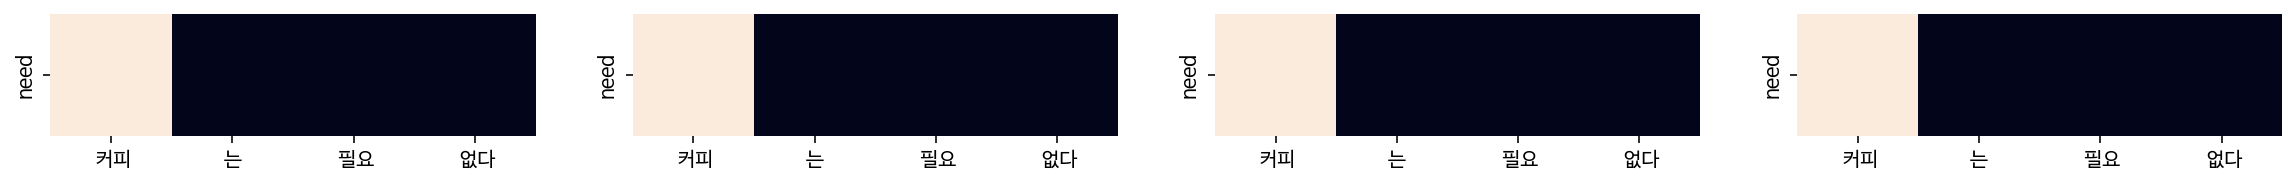

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead while another injured
Encoder Layer 1


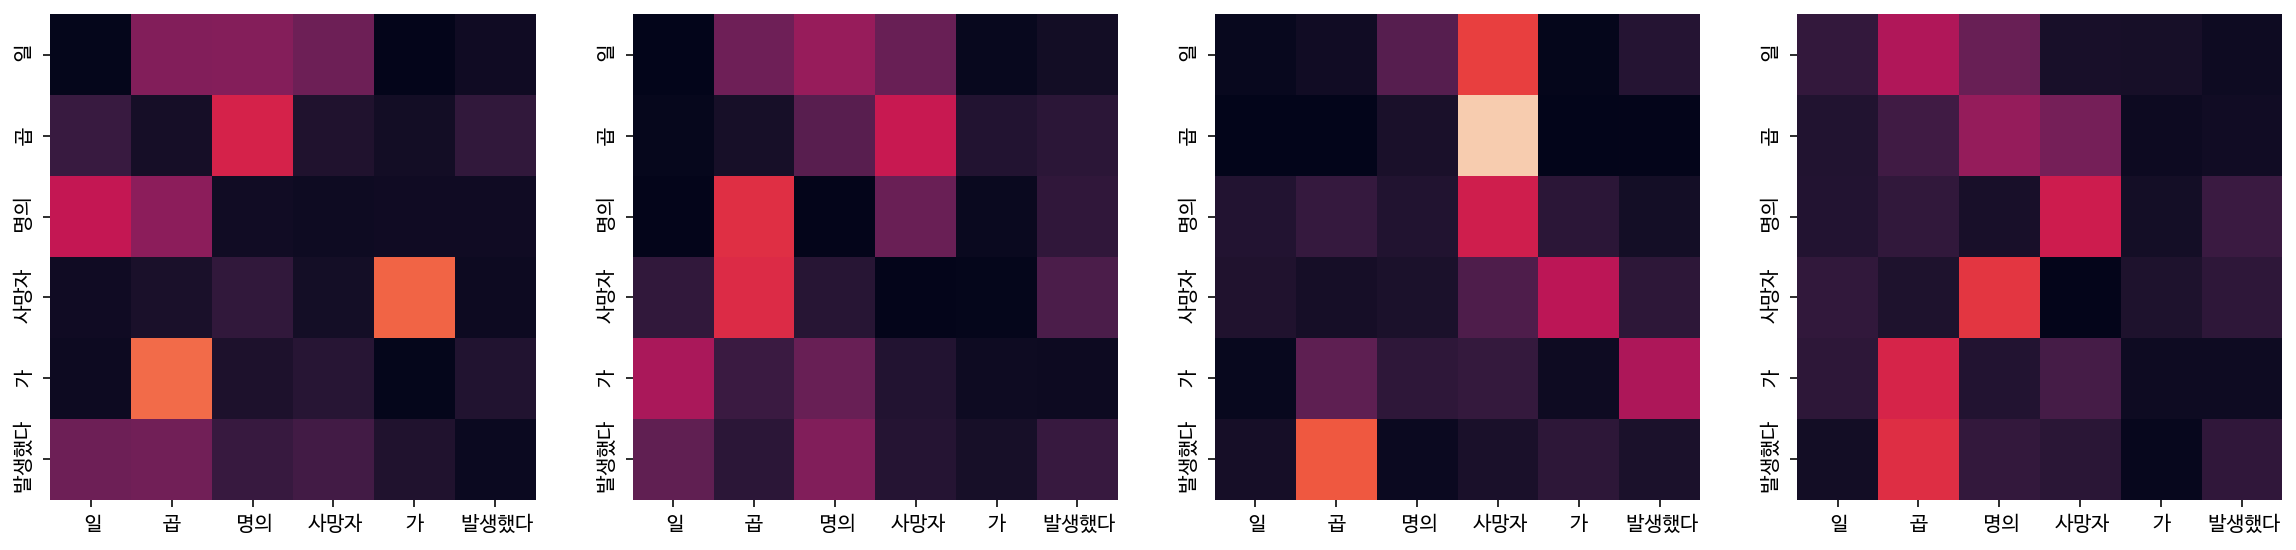

Encoder Layer 2


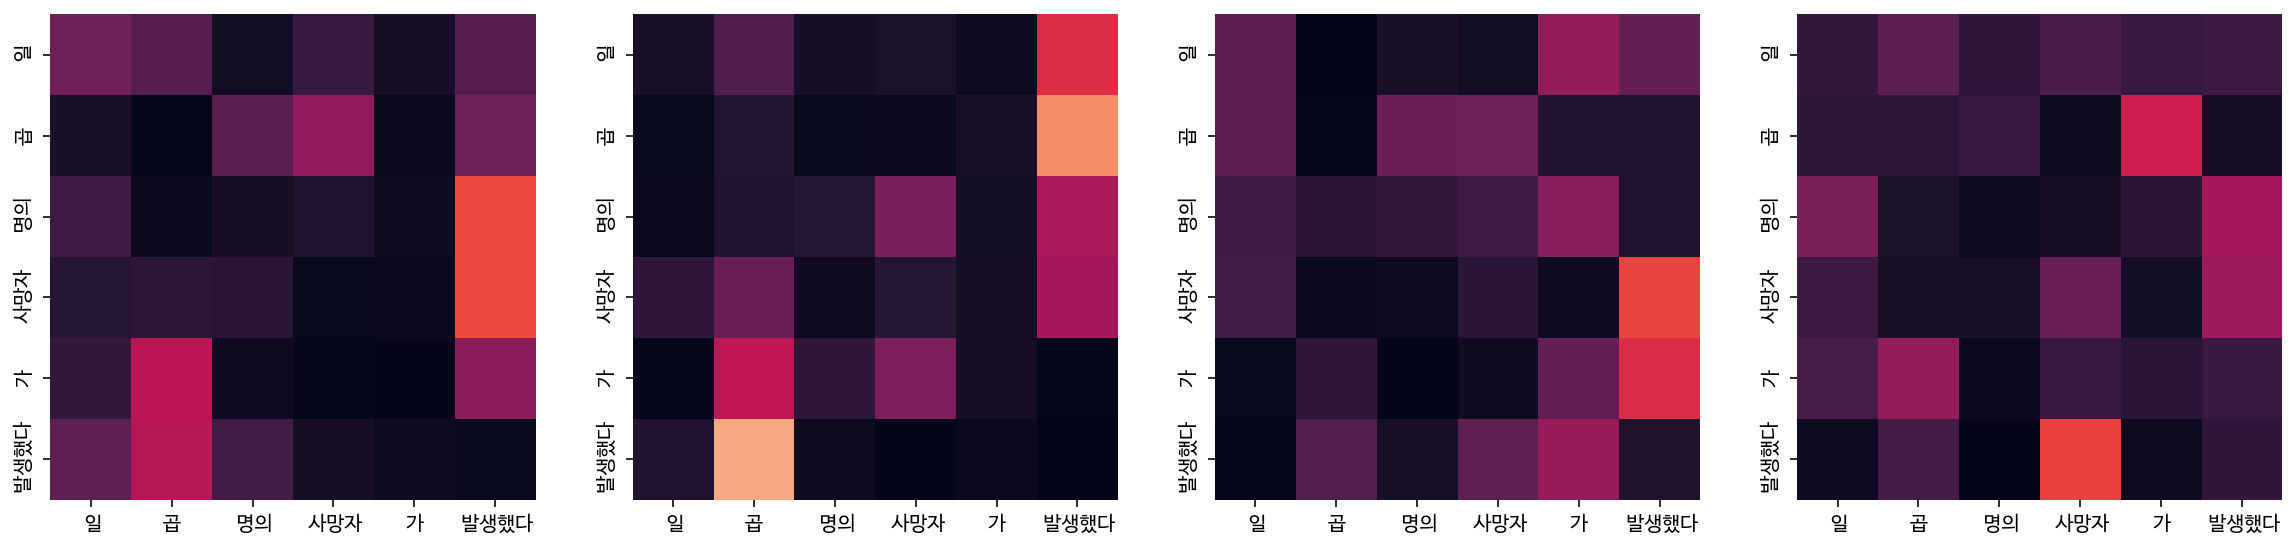

Decoder Self Layer 1


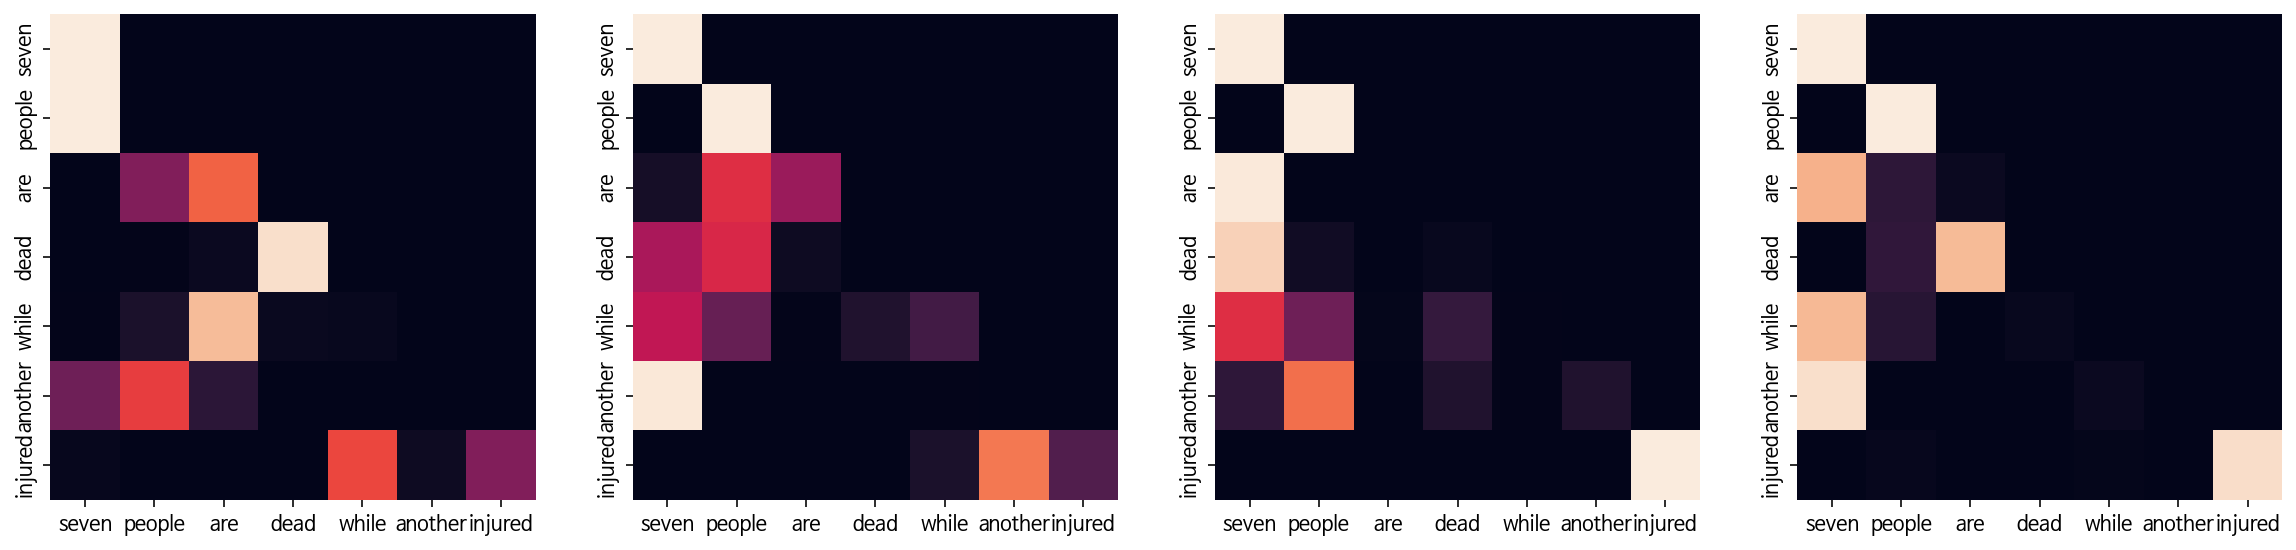

Decoder Src Layer 1


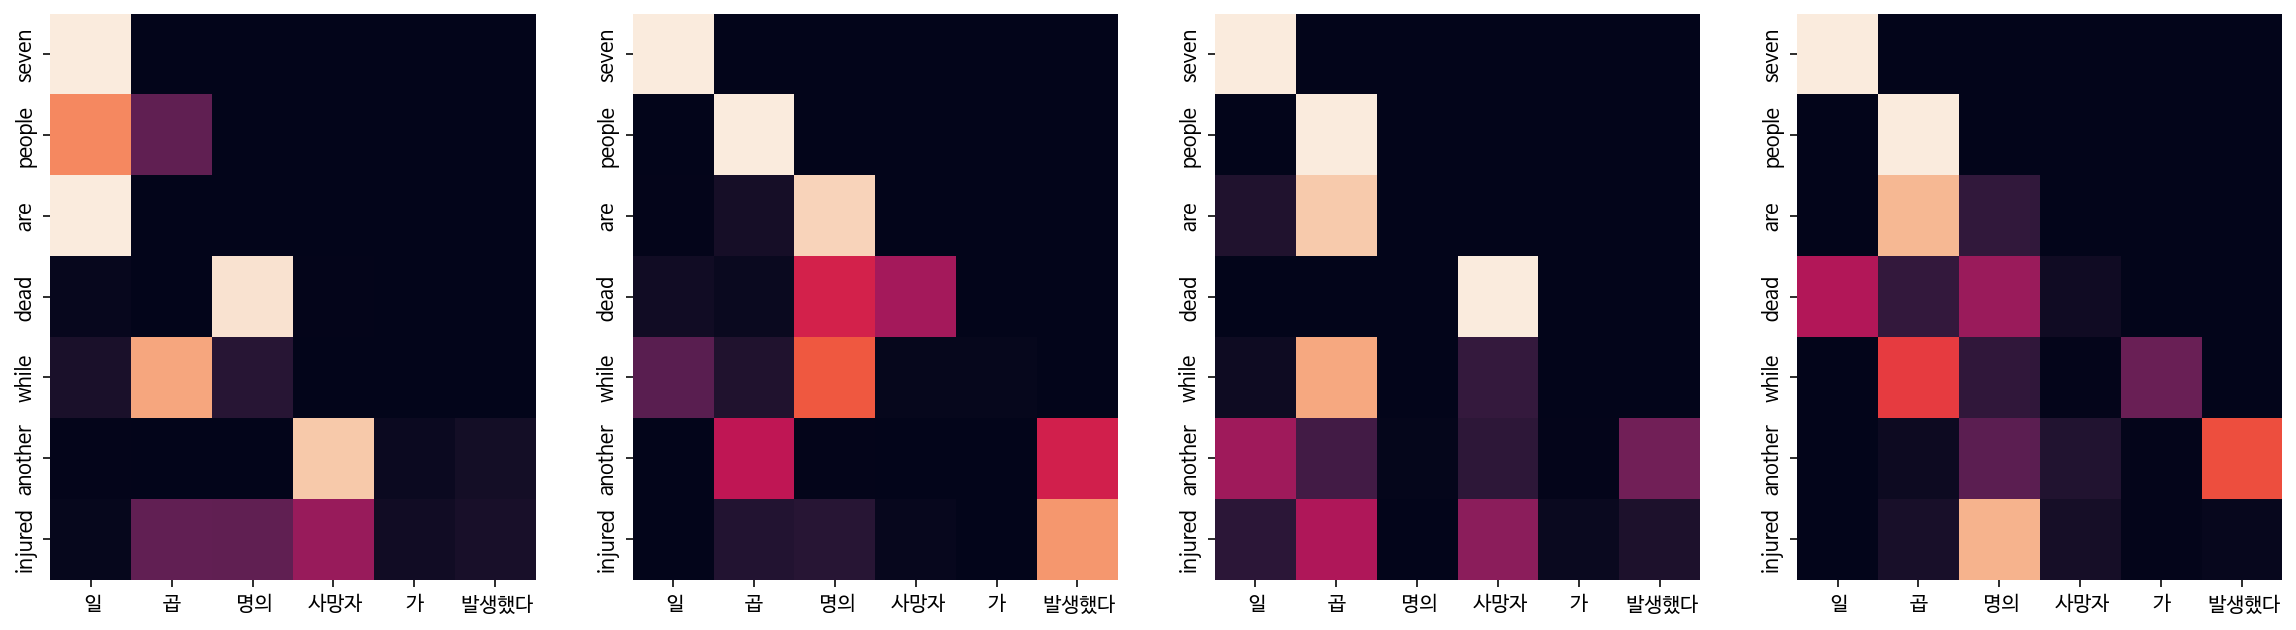

Decoder Self Layer 2


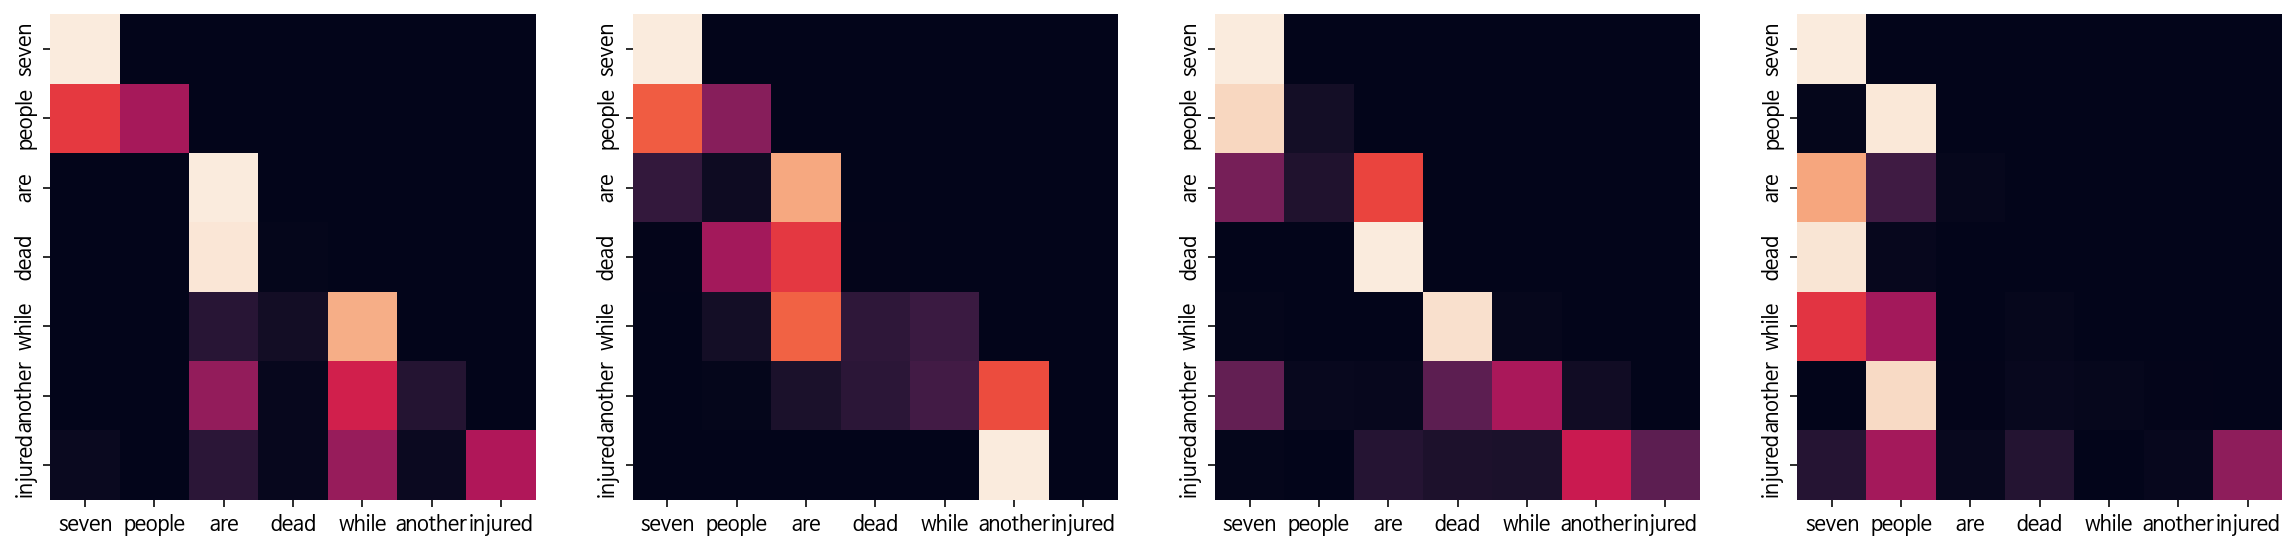

Decoder Src Layer 2


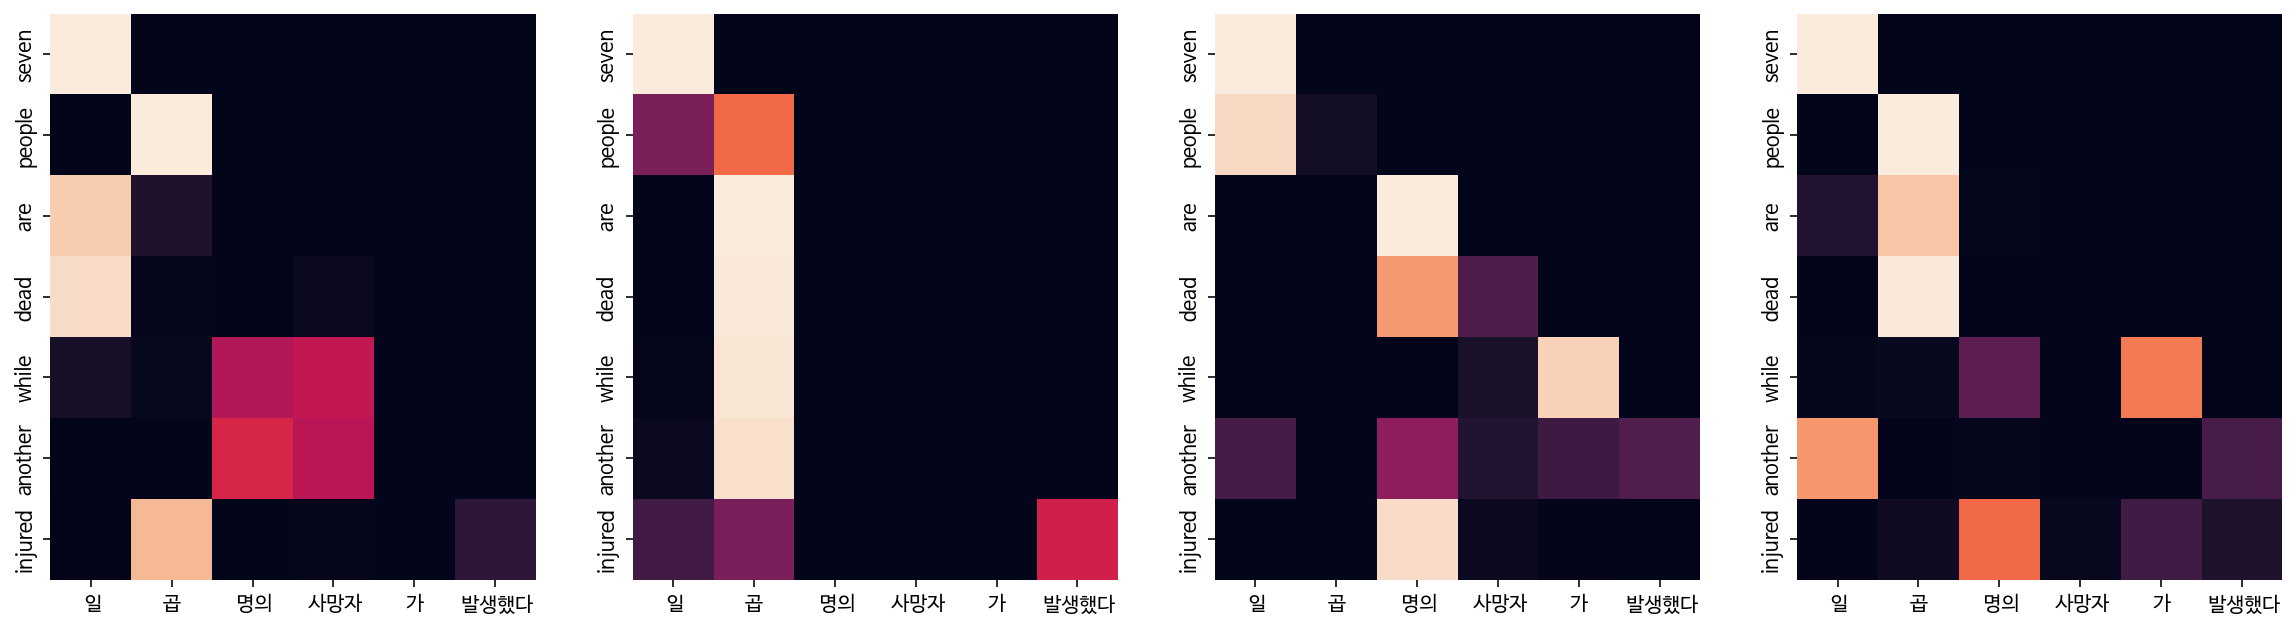

In [52]:
for idx, example in enumerate(examples):
    plot_attention = True
    translate(example, model, ko_tokenizer, en_tokenizer, plot_attention)
    print('='*50)

# 회고

* 앞서 진행한 GRU 기반 seq-to-seq 보다 적은 epoch을 돌려도(epoch=5) 번역 성능이 좋음을 확인함.
* epoch 5 이후에 loss가 7에서 3까지 밖에 안떨어지고 번역 성능이 우수하지는 않아서 epcoh을 10으로 설정하고 돌림.
* 번역 결과가 완벽하지는 않음.
* mask 생성 코드에 padding 마스크와 causality mask를 합치는 부분에서 __tf.minimum__ 으로 설정하고 돌렸는데 성능이 매우 안좋았음. 마스크로 가리고자 하는 부분을 __0__ 으로 마킹한줄 알았던 것이 문제였음. 0으로 가리기로 한 부분은 모두 가리기 위해 minimum이라 입력했는데 반대로 가리고자 했던 부분을 드러내고 학습시 드러나야 하는 부분을 모두 가려버려서 생긴 문제임.
* 알고보니 마스크로 가리고자 하는 부분을 1로 마킹했고, 이에 맞게 __tf.maximum__ 으로 설정한 뒤 돌리니 번역 성능이 준수하게 나왔음.
>dec_enc_mask = tf.__maximum__(enc_mask, dec_enc_causality_mask)<br>
dec_mask = tf.__maximum__(dec_mask, dec_causality_mask)

* Scaled dot product attention에서 embedding layer의 차원수에 루트 씌운 값으로 나눠 scaling 해주는 이유
    1. __Stability of softmax__: The softmax function is used to calculate the attention weights. When the dot product values in the numerator become large, the resulting softmax probabilities can become extremely close to 0 or 1. This makes it harder for the model to differentiate between different attention weights and can lead to numerical instability during training. Scaling down the dot product by the square root of d_k helps prevent extreme values in the softmax and ensures more stable and interpretable attention weights.

    2. __Balancing gradients__: During backpropagation, gradients flow through the attention mechanism. Large gradients can cause issues like exploding gradients, where the gradients become very large and lead to unstable training. By scaling down the dot product, the gradients are also scaled down, which helps balance the gradients and make the training process more stable.

     3. __Attention focus__: Scaling the dot product can affect the attention focus of the model. When the values in the dot product are small, the resulting attention weights will be influenced more by the actual content of the Key vectors. Conversely, when the values are large, the attention mechanism will be more driven by the magnitude of the Query vectors. Scaling helps balance these influences and allows the model to attend to relevant information based on both content and magnitude.

    - Overall, the scaling calculation in scaled dot product attention helps maintain stability, balance gradients, and control the attention focus, leading to more effective and stable training of Transformer models.
    
    - Dividing the dot product by this positive scaling factor __reduces the magnitude of the dot product.__ By scaling down the dot product, the resulting attention __weights are more balanced and stable.__ It __prevents extreme values in the softmax probabilities,__ making them less likely to be close to 0 or 1. It also helps __control the influence of Query and Key magnitudes__ on the attention mechanism, allowing for a more controlled and focused attention process.